# NLP: Search Engine

In [1]:
from nltk.tokenize import word_tokenize
import sqlite3

conn = sqlite3.connect('news.db')
cur = conn.cursor()


def 어절(sentence, n=2):
    tokens = word_tokenize(sentence)
    return [
        tuple(tokens[token:token + n])
        for token in range(len(tokens) - (n - 1))
    ]


def 음절(sentence, n=2):
    tokens = list(sentence)
    return [''.join(tokens[i:i + n]) for i in range(len(tokens))]

In [2]:
query = """
    SELECT id, url, content, date
    FROM news;
"""
cur.execute(query)
corpus = cur.fetchall()
corpus = [news[2] for news in corpus]

---

In [3]:
import re
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
pattern1 = re.compile(f'{re.escape(punctuation)}')
pattern2 = re.compile(r'[A-Za-z]{5,}')
pattern3 = re.compile(r'[^ 0-9A-Za-z가-힣]')
pattern4 = re.compile(r'\n{2,}')

In [5]:
collection = [
    pattern4.sub('',
                 pattern3.sub('',
                              pattern2.sub('',
                                           pattern1.sub('', _)))).strip()
    for _ in corpus
]

- Tokenizer (어절, 형태소, ngram)
- ngram: Stemming / Normalization (길이, 빈도) --> stopwording

In [6]:
len(word_tokenize(collection[0])), len(collection[0].split())

(515, 515)

In [7]:
len(collection[0].split()), len(어절(collection[0])), len(음절(collection[0]))

(515, 514, 2146)

In [8]:
from konlpy.tag import Kkma
kkma = Kkma()

C:\Users\u\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [9]:
Vocabulary = []

for _ in collection:
    Vocabulary.extend(_.split())
    Vocabulary.extend(어절(_))
    Vocabulary.extend(음절(_))
    Vocabulary.extend(kkma.morphs(_))

In [10]:
len(Vocabulary), len(set(Vocabulary))

(110740, 28262)

In [11]:
Vocabulary = [_ for _ in list(set(Vocabulary)) if 1 < len(_) < 6]

In [12]:
len(Vocabulary)

26849

In [13]:
BoM = []
for d in collection:
    docVector = [0 for _ in range(len(Vocabulary))]
    BoMCollection = d.split() + 어절(d) + 음절(d) + kkma.morphs(d)
    for _ in BoMCollection:
        if _ in Vocabulary:
            docVector[Vocabulary.index(_)] = 1
    BoM.append(docVector)

BoM의 문제점은 Sparse하다 (복잡도가 증가한다)

In [14]:
[(sum(_), len(Vocabulary) - sum(_)) for _ in BoM]

[(1753, 25096),
 (1753, 25096),
 (1156, 25693),
 (1321, 25528),
 (1745, 25104),
 (1451, 25398),
 (625, 26224),
 (1073, 25776),
 (1387, 25462),
 (1195, 25654),
 (1690, 25159),
 (2229, 24620),
 (1545, 25304),
 (1137, 25712),
 (1825, 25024),
 (1969, 24880),
 (1070, 25779),
 (1089, 25760),
 (933, 25916),
 (1030, 25819),
 (1433, 25416),
 (1274, 25575),
 (1612, 25237),
 (572, 26277),
 (1311, 25538),
 (1359, 25490),
 (1312, 25537),
 (1507, 25342),
 (1644, 25205),
 (976, 25873),
 (1844, 25005),
 (1774, 25075),
 (1074, 25775),
 (945, 25904),
 (848, 26001),
 (635, 26214)]

In [15]:
Query = ['대통령', '청와대']
totalResult = []
for q in Query:
    searchResult = []
    for i, d in enumerate(BoM):
        for j, b in enumerate(d):
            if b == 1 and j == Vocabulary.index(q):
                searchResult.append(i)
                break
    totalResult.append(searchResult)

In [16]:
set(totalResult[0]).intersection(totalResult[1])

{0, 1, 30}

## DTM & TDM

밑의 코드처럼 DTM과 TDM으로 자료구조를 만들어 놓으면 loop를 줄일 수 있다.

In [17]:
from collections import defaultdict

DTM = defaultdict(lambda: defaultdict(int))
for i, d in enumerate(BoM):
    for j, t in enumerate(d):
        if t == 1:
            DTM[i][j] = t

In [18]:
sum(DTM[0].values())

1753

In [19]:
TDM = defaultdict(lambda: defaultdict(int))

for i, termDict in DTM.items():
    for j, b in termDict.items():
        TDM[j][i] = b

In [20]:
searchResult = []
for q in Query:
    j = Vocabulary.index(q)
    searchResult.append(list(TDM[j].keys()))

In [21]:
set(totalResult[0]).intersection(totalResult[1])

{0, 1, 30}

### 성능 차이
Q = Query, D = Full Documents라고 했을 때,
- BoM = O(|Q| * D * |D|)
- TDM = O(|Q| * avg(|D|))

In [22]:
termVector = list(
    list(0 for _ in range(len(collection))) for _ in range(len(Vocabulary)))
for j, docDict in TDM.items():
    for i in range(len(collection)):
        termVector[j][i] = docDict[i]

In [23]:
import numpy as np
_BoM = np.array(termVector)

In [24]:
sum(_BoM.T[0])

1753

In [25]:
sum(BoM[0])

1753

In [26]:
_BoM[0]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
D = [['A', 'B'], ['C', 'D'], ['A', 'C']]

Dictionary = defaultdict(lambda: -1)
Postings = []

V = []

for j, d in enumerate(D):
    for t in d:
        if t not in V:
            V.append(t)
        i = V.index(t)
        nextPosition = Dictionary[i]
        _struct = (j, 1, nextPosition)
        Dictionary[i] = len(Postings)
        Postings.append(_struct)

In [28]:
Dictionary

defaultdict(<function __main__.<lambda>()>, {0: 4, 1: 1, 2: 5, 3: 3})

In [29]:
Postings

[(0, 1, -1), (0, 1, -1), (1, 1, -1), (1, 1, -1), (2, 1, 0), (2, 1, 2)]

In [30]:
Q = ['C']

for q in Q:
    i = V.index(q)
    nextPosition = Dictionary[i]
    while True:
        _struct = Postings[nextPosition]
        nextPosition = _struct[2]
        print(f'{_struct[0]+1}번째 문서, {_struct[1]}번, 다음 위치: {_struct[2]}')

        if nextPosition == -1:
            break

3번째 문서, 1번, 다음 위치: 2
2번째 문서, 1번, 다음 위치: -1


---

posting된 데이터들을 파일로 저장한다.

In [31]:
D = [['A', 'B'], ['C', 'D'], ['A', 'C']]

Dictionary = defaultdict(lambda: -1)
Postings = open('postings.dst', 'w')

V = []

for j, d in enumerate(D):
    for t in d:
        if t not in V:
            V.append(t)
        i = V.index(t)
        nextPosition = Dictionary[i]
        _struct = (str(j), str(1), str(nextPosition))
        Dictionary[i] = Postings.tell()
        Postings.write(','.join(_struct) + '\n')
Postings.close()

In [32]:
Q = ['C']
Postings = open('postings.dst')

for q in Q:
    i = V.index(q)
    nextPosition = Dictionary[i]
    while True:
        Postings.seek(nextPosition)
        _struct = Postings.readline().split(',')
        nextPosition = int(_struct[2])
        print(f'{int(_struct[0])+1}번째 문서, {_struct[1]}번, 다음 위치: {_struct[2]}')

        if nextPosition == -1:
            break
Postings.close()

3번째 문서, 1번, 다음 위치: 16

2번째 문서, 1번, 다음 위치: -1



---

posting된 데이터들을 byte 형식으로 저장한다.
- https://docs.python.org/2/library/struct.html

In [33]:
from struct import pack

D = [['A', 'B'], ['C', 'D'], ['A', 'C']]

Dictionary = defaultdict(lambda: -1)
Postings = open('postings.dst', 'wb')

V = []

for j, d in enumerate(D):
    for t in d:
        if t not in V:
            V.append(t)
        i = V.index(t)
        nextPosition = Dictionary[i]
        _struct = pack('iii', j, 1, nextPosition)
        Dictionary[i] = Postings.tell()
        Postings.write(_struct)
Postings.close()

In [34]:
with open('postings.dst', 'rb') as fp:
    print(fp.read())

b'\x00\x00\x00\x00\x01\x00\x00\x00\xff\xff\xff\xff\x00\x00\x00\x00\x01\x00\x00\x00\xff\xff\xff\xff\x01\x00\x00\x00\x01\x00\x00\x00\xff\xff\xff\xff\x01\x00\x00\x00\x01\x00\x00\x00\xff\xff\xff\xff\x02\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x01\x00\x00\x00\x18\x00\x00\x00'


In [35]:
from struct import unpack

Q = ['C']
Postings = open("postings.dst", 'rb')

for q in Q:
    i = V.index(q)
    nextPosition = Dictionary[i]
    while True:
        Postings.seek(nextPosition)
        _struct = unpack("iii", Postings.read(4 * 3))
        nextPosition = int(_struct[2])
        print(f'{int(_struct[0])+1}번째 문서, {_struct[1]}번, 다음 위치: {_struct[2]}')

        if nextPosition == -1:
            break
Postings.close()

3번째 문서, 1번, 다음 위치: 24
2번째 문서, 1번, 다음 위치: -1


In [36]:
D = [
    ['A', 'B'],
    ['C', 'D'],
    ['A', 'C'],
]

TDM = defaultdict(lambda: defaultdict(int))
Dictionary = defaultdict(lambda: -1)

V = list()
for j, d in enumerate(D):
    for t in d:
        if t not in V:
            V.append(t)
        i = V.index(t)
        TDM[i][j] = 1

In [37]:
Q = ['A', 'C']

for q in Q:
    i = V.index(q)
    nextPosition = Dictionary[i]
    for d, b in TDM[i].items():
        print(f'{d}번째 문서, {b}번')

0번째 문서, 1번
2번째 문서, 1번
1번째 문서, 1번
2번째 문서, 1번


## 자료구조에 빈도까지 포함하기

In [38]:
V = []
D = []

DTM = defaultdict(lambda: defaultdict(int))

for d in collection:
    i = len(D)
    D.append(i)

    for t in [_[0] for _ in kkma.pos(d) if _[1].startswith('N')]:
        if t not in V:
            V.append(t)
        j = V.index(t)
        DTM[i][j] += 1

In [39]:
len(V), len(D)

(3165, 36)

In [40]:
TDM = defaultdict(lambda: defaultdict(int))

for i, terms in DTM.items():
    for j, f in terms.items():
        TDM[j][i] = f

In [41]:
for j, docs in TDM.items():
    for i, f in docs.items():
        print(V[j], D[i], f)
    print()

고민 0 2
고민 1 2
고민 15 1
고민 24 1
고민 26 1
고민 30 1

정 0 2
정 1 2
정 2 1
정 3 1
정 4 1
정 6 5
정 9 2
정 10 3
정 14 1
정 22 1
정 24 8
정 29 1
정 30 1
정 33 1

청와대 0 9
청와대 1 9
청와대 2 1
청와대 7 1
청와대 30 2

대변인 0 6
대변인 1 6
대변인 30 2

뉴 0 1
뉴 1 1
뉴 8 2
뉴 20 6
뉴 21 1
뉴 24 1

시스 0 1
시스 1 1
시스 8 2
시스 20 6
시스 21 1
시스 24 1

17 0 1
17 1 1
17 2 3
17 3 2
17 4 1
17 5 3
17 7 3
17 8 3
17 9 3
17 10 2
17 12 1
17 14 1
17 15 1
17 16 2
17 17 1
17 18 1
17 19 1
17 20 3
17 21 1
17 22 1
17 23 1
17 24 1
17 25 1
17 30 1
17 31 2
17 32 2
17 33 1
17 34 1
17 35 1

일 0 9
일 1 9
일 2 4
일 3 7
일 4 1
일 5 3
일 6 3
일 7 3
일 8 7
일 9 3
일 10 9
일 11 4
일 12 1
일 13 2
일 14 2
일 15 1
일 16 6
일 17 1
일 18 2
일 19 2
일 20 12
일 21 2
일 22 2
일 23 1
일 24 3
일 25 1
일 26 5
일 27 3
일 28 10
일 29 1
일 30 7
일 31 10
일 32 2
일 33 1
일 34 1
일 35 1

한국 0 12
한국 1 12
한국 2 9
한국 4 10
한국 7 3
한국 8 5
한국 10 5
한국 12 1
한국 13 3
한국 14 5
한국 15 1
한국 16 3
한국 19 3
한국 20 7
한국 23 2
한국 27 3
한국 28 13
한국 30 23
한국 31 8
한국 32 3

겨냥 0 1
겨냥 1 1
겨냥 20 1
겨냥 28 1
겨냥 30 1

일본 0 13
일본 1 13
일본 2 3
일본 4 7
일본 7 3
일

언론 28 2
언론 30 9

객관적 0 1
객관적 1 1
객관적 11 1

시각 0 2
시각 1 2
시각 4 1
시각 25 1

당부 0 1
당부 1 1
당부 31 1

말 0 1
말 1 1
말 2 1
말 3 2
말 7 1
말 8 1
말 11 3
말 21 1
말 25 1
말 26 1
말 28 2
말 32 1
말 33 1

여파 0 1
여파 1 1

내일 0 1
내일 1 1
내일 14 1

재인 0 1
재인 1 1
재인 27 1
재인 28 1

여야 0 1
여야 1 1
여야 10 1
여야 16 2
여야 20 1

당 0 1
당 1 1
당 5 1
당 8 9
당 9 2
당 10 6
당 13 1
당 16 7
당 20 9
당 24 1
당 26 1
당 34 1

대표 0 1
대표 1 1
대표 8 4
대표 10 1
대표 11 1
대표 15 1
대표 16 3
대표 20 1
대표 21 2
대표 29 1
대표 30 1
대표 32 1
대표 33 1

회동 0 1
회동 1 1
회동 2 6

부분 0 1
부분 1 1
부분 2 1
부분 7 1
부분 8 1
부분 15 2
부분 24 3

생각 0 1
생각 1 1
생각 2 1
생각 3 3
생각 6 1
생각 7 1
생각 8 1
생각 14 1
생각 20 3
생각 21 2
생각 24 4
생각 25 1
생각 26 1

반문 0 1
반문 1 1
반문 15 2

목 0 1
목 1 1
목 11 1
목 14 1

소리 0 1
소리 1 1
소리 3 1
소리 11 1
소리 14 1

정확 0 1
정확 1 1

전달 0 1
전달 1 1
전달 9 1
전달 25 1

부연 0 1
부연 1 1

기자 0 1
기자 1 1
기자 2 4
기자 3 1
기자 4 3
기자 5 6
기자 7 3
기자 8 2
기자 9 1
기자 10 3
기자 12 1
기자 13 1
기자 14 3
기자 15 2
기자 16 1
기자 17 1
기자 18 1
기자 19 1
기자 20 2
기자 21 1
기자 22 1
기자 23 5
기자 24 1
기자 25 1
기자 26 1
기자 27 4
기자 28 1
기

전환 30 1
전환 32 1

동시 4 1
동시 25 1
동시 35 1

이외 4 1

다변화 4 3

산업별 4 1

수립 4 1

리스크 4 4

완화 4 1
완화 10 1
완화 11 3
완화 15 1
완화 27 3
완화 34 1

집중화 4 1

대안 4 1
대안 6 1

베트남 4 1

인도네시아 4 1

부상 4 1

성장 4 1
성장 5 2
성장 12 1
성장 32 1

도처 4 1

진출 4 1
진출 15 1

요인 4 1

철저 4 1

점검 4 1
점검 31 2

조언 4 1

발간 4 1

세미나 4 1

개최 4 1
개최 9 1

지원단 4 1
지원단 8 1

인적 4 1

물적 4 1

자원 4 1

부족 4 1
부족 15 2

관리 4 1
관리 10 1
관리 15 2
관리 24 1
관리 28 4
관리 30 2
관리 33 2
관리 34 1

대응 4 2
대응 8 1
대응 11 1
대응 14 2
대응 15 1
대응 25 1
대응 30 1

중소 4 1

중견 4 1

하반기 4 1
하반기 31 1
하반기 32 1

정보 4 1
정보 11 1
정보 12 2

센터 4 1
센터 25 1

운영 4 1
운영 5 10
운영 15 1

방침 4 1
방침 13 1
방침 28 1
방침 31 1

간담회 4 2
간담회 5 3
간담회 8 1

수십 4 1
수십 18 1

상호 4 1

분업 4 1

특화 4 1
특화 5 1

발전 4 2
발전 5 1
발전 16 1

정치 4 1
정치 6 3
정치 8 1
정치 11 1
정치 24 1
정치 27 1
정치 30 2

혁명 4 1

시대 4 1
시대 5 1
시대 25 1
시대 32 1

추진 4 1
추진 5 2
추진 32 2

동력 4 1

우려 4 1
우려 10 1
우려 11 1
우려 14 2
우려 15 2
우려 27 1
우려 28 1

만약 4 1

각오 4 1

기존 4 1
기존 5 1
기존 15 4
기존 17 3
기존 25 1
기존 31 1
기존 32 2
기존 34 1

중소기업 4 1
중소기업 15 1



시정 19 1

하라 11 1
하라 18 1
하라 25 1

증거 11 2

악재 11 3
악재 14 8

대면 11 4

난항 11 1
난항 31 1

트럼프 11 14
트럼프 14 1
트럼프 27 2

시진 11 3
시진 14 1
시진 27 1

맨 11 3

뉴욕 11 1
뉴욕 14 1
뉴욕 28 1

데일리 11 3
데일리 12 3

특파원 11 1
특파원 25 1
특파원 28 1

3250 11 1

383 11 1

어치 11 1
어치 29 1

관세 11 8

부과 11 3
부과 15 1
부과 33 2

오른쪽 11 1

카드 11 1
카드 26 9
카드 27 1
카드 28 1

16 11 1
16 20 1
16 22 1
16 24 1
16 27 1
16 28 1
16 29 1

현지 11 1
현지 23 2
현지 26 3
현지 28 1
현지 29 1

백악관 11 3

각료 11 2
각료 30 1

타결 11 1

지난달 11 1
지난달 29 1

29 11 1
29 32 1

오사카 11 1

왼쪽 11 1

주석 11 3
주석 27 1

휴전 11 1

으름장 11 1

그동안 11 1
그동안 14 1
그동안 22 1
그동안 27 2

틈 11 1

압박 11 1
압박 28 1

우후죽순 11 1

양국 11 6
양국 28 1
양국 30 1
양국 31 2

싸움 11 1

잡기 11 1

요원 11 1

관측 11 1
관측 28 1

충돌 11 1
충돌 16 1
충돌 20 4

돌발 11 1

판정 11 3
판정 27 1

변수 11 1

발단 11 1

미국산 11 1

확대 11 1
확대 12 1
확대 14 3
확대 27 3
확대 31 3
확대 32 1

측이 11 1
측이 21 1

트위터 11 1
트위터 28 1
트위터 35 1

농부 11 1

로 11 2
로 18 1
로 27 2
로 30 1
로 32 6

농산품 11 1

실망 11 1

농촌 11 1
농촌 17 1

핵심적 11 1
핵심적 27 1

지지층 11 1

매체 11 1

잔영 22 1

출연자 22 1

시청률 22 2

한자리 22 1

리턴 22 1

고현 22 2

정은 22 1

이견 22 1
이견 34 1

부작 22 1

바통 22 1

기록 22 1

주인공 22 1

선전 22 1

이태 22 3

예원 22 1

욕설 22 1

반향 22 1

동쪽 22 1

본인 22 1
본인 24 1

정음 22 1

등장 22 1

정원 22 1

케이 22 1
케이 30 1

불매 23 1
불매 27 1

포스터 23 1

커뮤니티 23 1

자발적 23 2

여행 23 5

투어 23 5

빈축 23 1

관광 23 2

홍보 23 1

마케팅 23 1

경비 23 1

초청 23 2

행사 23 1

출국 23 1
출국 31 2

참가 23 2

변명 23 1

포기 23 1

공짜 23 1

양잿물 23 1

울분 23 1

박정 23 1

재테크 23 1

비법 23 1

박학 23 1

다식 23 1

럼 23 1

정신과 24 3

전문의 24 9

누리 24 1

극단적 24 5

고인 24 1

혼자 24 1

정신 24 1

학과 24 1

호성 24 1

출발 24 1

아침 24 2
아침 25 1

징후 24 2

고백 24 1

완치 24 1

상담 24 3

역설 24 1

누군가 24 1
누군가 26 1

자존심 24 1

스스로 24 1

극복 24 2

지라 24 1

약물 24 1

의학적 24 1

처방 24 1

당일 24 1

자아 24 1

심리적 24 1

면모 24 1

정리 24 1

며칠 24 1

이분 24 1

이상향 24 1

평론가 24 1

추측 24 1

지위 24 1

서대문구 24 1

홍은동 24 1

북한산 24 1

자락 24 1

산 24 1

42 24 1

부인 24 1

자택 24 1

감식 24 1

검시 24 1

타살 24 1

존중 24 1

부검 24 1

우울감 24 1

자살 24 1

1393 24 1

생명 24 1
생명 34 2



---

Posting해서 파일로 저장하는 방식

In [42]:
V = []
D = []
Dictionary = defaultdict(lambda: -1)
Postings = []

DTM = defaultdict(lambda: defaultdict(int))

for d in collection:
    i = len(D)
    D.append(i)
    localPostings = defaultdict(int)

    for t in [_[0] for _ in kkma.pos(d) if _[1].startswith('N')]:
        if t not in V:
            V.append(t)
        j = V.index(t)
        localPostings[j] += 1

    for j, f in localPostings.items():
        nextPosition = Dictionary[j]
        _struct = (i, f, nextPosition)
        Dictionary[j] = len(Postings)
        Postings.append(_struct)

In [43]:
for j, _ in enumerate(V):
    nextPosition = Dictionary[j]
    while True:
        _struct = Postings[nextPosition]
        nextPosition = _struct[2]
        print(V[j], D[_struct[0]], _struct[1])

        if nextPosition == -1:
            break

고민 30 1
고민 26 1
고민 24 1
고민 15 1
고민 1 2
고민 0 2
정 33 1
정 30 1
정 29 1
정 24 8
정 22 1
정 14 1
정 10 3
정 9 2
정 6 5
정 4 1
정 3 1
정 2 1
정 1 2
정 0 2
청와대 30 2
청와대 7 1
청와대 2 1
청와대 1 9
청와대 0 9
대변인 30 2
대변인 1 6
대변인 0 6
뉴 24 1
뉴 21 1
뉴 20 6
뉴 8 2
뉴 1 1
뉴 0 1
시스 24 1
시스 21 1
시스 20 6
시스 8 2
시스 1 1
시스 0 1
17 35 1
17 34 1
17 33 1
17 32 2
17 31 2
17 30 1
17 25 1
17 24 1
17 23 1
17 22 1
17 21 1
17 20 3
17 19 1
17 18 1
17 17 1
17 16 2
17 15 1
17 14 1
17 12 1
17 10 2
17 9 3
17 8 3
17 7 3
17 5 3
17 4 1
17 3 2
17 2 3
17 1 1
17 0 1
일 35 1
일 34 1
일 33 1
일 32 2
일 31 10
일 30 7
일 29 1
일 28 10
일 27 3
일 26 5
일 25 1
일 24 3
일 23 1
일 22 2
일 21 2
일 20 12
일 19 2
일 18 2
일 17 1
일 16 6
일 15 1
일 14 2
일 13 2
일 12 1
일 11 4
일 10 9
일 9 3
일 8 7
일 7 3
일 6 3
일 5 3
일 4 1
일 3 7
일 2 4
일 1 9
일 0 9
한국 32 3
한국 31 8
한국 30 23
한국 28 13
한국 27 3
한국 23 2
한국 20 7
한국 19 3
한국 16 3
한국 15 1
한국 14 5
한국 13 3
한국 12 1
한국 10 5
한국 8 5
한국 7 3
한국 4 10
한국 2 9
한국 1 12
한국 0 12
겨냥 30 1
겨냥 28 1
겨냥 20 1
겨냥 1 1
겨냥 0 1
일본 31 12
일본 30 25
일본 28 18
일본 27 22
일본 26 1
일본 2

건 21 1
건 20 3
건 11 1
건 10 2
건 1 1
건 0 1
이전 1 1
이전 0 1
항의 10 2
항의 1 1
항의 0 1
뜻 25 1
뜻 24 1
뜻 23 1
뜻 8 1
뜻 1 1
뜻 0 1
표명 1 1
표명 0 1
책임 25 2
책임 24 1
책임 20 1
책임 18 2
책임 8 1
책임 1 1
책임 0 1
희망 19 1
희망 7 2
희망 2 1
희망 1 1
희망 0 1
도움 33 1
도움 24 2
도움 17 2
도움 2 1
도움 1 2
도움 0 2
편향 1 1
편향 0 1
자제 1 1
자제 0 1
경고 1 2
경고 0 2
메시지 1 1
메시지 0 1
논란 25 2
논란 23 2
논란 22 3
논란 21 2
논란 15 1
논란 8 4
논란 5 1
논란 1 1
논란 0 1
구설 22 1
구설 1 1
구설 0 1
포문 1 1
포문 0 1
이례적 11 1
이례적 6 1
이례적 1 1
이례적 0 1
실명 1 1
실명 0 1
구체적 30 1
구체적 25 1
구체적 1 1
구체적 0 1
배경 28 1
배경 11 1
배경 1 1
배경 0 1
균형 1 1
균형 0 1
감각 7 1
감각 1 1
감각 0 1
채 30 1
채 26 1
채 24 1
채 19 1
채 1 1
채 0 1
경제 35 7
경제 31 1
경제 30 2
경제 28 2
경제 27 2
경제 23 1
경제 14 4
경제 13 2
경제 12 1
경제 11 7
경제 7 5
경제 4 2
경제 1 1
경제 0 1
보복 30 1
보복 28 2
보복 27 3
보복 11 1
보복 1 1
보복 0 1
국면 1 1
국면 0 1
판단 31 1
판단 30 1
판단 28 1
판단 25 1
판단 14 1
판단 9 3
판단 8 8
판단 4 1
판단 1 1
판단 0 1
의미 15 1
의미 12 1
의미 4 1
의미 2 1
의미 1 1
의미 0 1
분석 31 2
분석 30 1
분석 29 1
분석 24 1
분석 17 1
분석 14 1
분석 12 3
분석 1 1
분석 0 1
핵심 33 1
핵심 32 1
핵심 31 2
핵심 25 2


미 11 4
미 7 2
미 4 3
무역 31 2
무역 30 3
무역 28 3
무역 27 12
무역 14 10
무역 11 8
무역 4 5
분쟁 31 1
분쟁 27 1
분쟁 14 8
분쟁 4 2
중국 31 3
중국 27 3
중국 14 5
중국 12 12
중국 11 22
중국 4 16
특성 14 1
특성 4 1
계속 32 1
계속 30 1
계속 24 2
계속 15 1
계속 4 1
장기화 4 3
전망 33 1
전망 31 2
전망 28 1
전망 25 1
전망 16 1
전망 15 3
전망 14 2
전망 12 2
전망 4 1
만큼 25 1
만큼 14 1
만큼 13 2
만큼 11 1
만큼 8 1
만큼 7 1
만큼 5 1
만큼 4 3
상수 4 1
두고 28 2
두고 9 2
두고 4 1
협회 4 1
제언 4 2
32 9 1
32 4 1
쪽 11 1
쪽 4 1
분량 33 2
분량 4 1
보고서 11 1
보고서 8 1
보고서 4 6
중간 22 1
중간 4 1
일정 34 1
일정 23 2
일정 20 1
일정 16 1
일정 13 1
일정 11 2
일정 10 11
일정 4 1
수준 35 1
수준 31 1
수준 15 1
수준 4 1
제기 28 1
제기 27 1
제기 11 1
제기 4 1
공산당 4 1
주도로 4 1
전체 10 9
전체 8 1
전체 4 1
유기적 4 1
주식 4 1
회사 30 1
회사 29 1
회사 4 1
구조 25 1
구조 19 2
구조 14 1
구조 13 1
구조 4 1
단기간 4 1
수록 4 1
앞 32 1
앞 27 1
앞 22 1
앞 21 2
앞 20 3
앞 16 1
앞 15 3
앞 4 3
3 34 3
3 32 4
3 31 3
3 30 2
3 29 4
3 28 3
3 26 1
3 24 1
3 22 1
3 20 3
3 19 3
3 17 4
3 16 1
3 13 2
3 12 2
3 10 3
3 8 5
3 5 1
3 4 1
국 31 1
국 30 1
국 28 1
국 27 1
국 4 1
우회 31 1
우회 4 3
직접 19 1
직접 4 1
흐름 31 1
흐름 21 1
흐름 1

의원 34 2
의원 24 8
의원 20 20
의원 16 18
의원 11 1
의원 10 13
의원 8 18
총회 8 4
여의도 20 1
여의도 10 1
여의도 8 2
국회 34 4
국회 20 8
국회 16 6
국회 13 2
국회 10 4
국회 8 3
보건 34 1
보건 33 1
보건 8 1
복지 8 1
참석 31 2
참석 20 1
참석 8 2
순례 8 3
자유 30 1
자유 27 1
자유 20 5
자유 16 1
자유 14 1
자유 10 2
자유 8 4
승희 8 1
518 8 3
망언 8 3
징계 8 7
지도부 10 1
지도부 8 6
용인 8 1
개월 31 1
개월 17 1
개월 8 5
당원 8 7
정지 26 4
정지 8 4
최고 29 1
최고 14 1
최고 8 9
위원 15 1
위원 14 3
위원 8 6
자격 15 1
자격 8 3
18 31 1
18 28 2
18 20 1
18 14 1
18 10 1
18 9 1
18 8 1
직무 8 1
수행 8 1
회복 17 1
회복 12 1
회복 8 4
당헌 8 1
당규 8 1
상 34 3
상 31 1
상 28 1
상 25 1
상 8 1
박탈 8 3
행 8 1
법적 34 1
법적 20 1
법적 8 3
지도 8 4
부가 8 2
정치적 30 1
정치적 28 2
정치적 24 1
정치적 10 1
정치적 8 3
도외 8 1
시한 28 1
시한 8 1
회피 8 1
지적도 34 1
지적도 12 1
지적도 8 2
박 31 2
박 27 1
박 22 2
박 21 6
박 20 1
박 17 2
박 16 1
박 9 2
박 8 4
맹우 8 2
사무총장 8 4
법률 20 1
법률 8 1
의뢰 24 1
의뢰 21 1
의뢰 8 2
직 8 1
결론 11 2
결론 9 1
결론 8 1
황 22 1
황 8 3
교 31 1
교 27 1
교 8 2
자동 8 1
19 25 1
19 10 3
19 8 1
윤리 8 2
처분 8 1
당내 8 2
선거권 8 2
활동 29 2
활동 24 1
활동 9 2
활동 8 1
활동도 8 1
중단 27 2
중단 25 1
중단 11 1
중단

증가 17 2
증가 12 1
양호 12 2
편 30 1
편 12 1
차별화 32 2
차별화 12 1
약화 27 2
약화 14 1
약화 12 1
방한 12 1
구축 12 2
한방 12 1
실제 31 1
실제 14 1
실제 12 1
475 12 1
급등 14 1
급등 12 1
영현 12 1
세계적 12 1
입증 30 1
입증 12 1
만이 12 1
성공적 32 1
성공적 12 1
안착 12 1
고성 12 1
후가 12 1
유리 12 1
유로 12 1
모니터 12 1
향후 31 2
향후 12 1
연평균 12 1
83 20 2
83 12 1
배 33 2
배 20 3
배 17 3
배 16 1
배 12 1
158 12 1
설화 12 1
수라 12 1
도가 32 1
도가 12 1
못 12 1
약세 12 1
바닥권 12 1
낙관 12 1
독보적 12 1
포트폴리오 12 1
보유 15 1
보유 12 1
내수 12 1
대부분 33 1
대부분 12 2
네오 12 1
092730 12 1
0201 12 1
민간 27 1
민간 13 3
택지 13 3
아파트 13 7
양가 13 5
상한제 13 6
적용 33 1
적용 13 7
가운데 31 2
가운데 30 1
가운데 23 1
가운데 20 2
가운데 17 1
가운데 14 1
가운데 13 1
시세 13 3
분양 13 16
가로 13 1
처지 13 1
공공 13 16
임대 15 2
임대 13 14
주택 18 1
주택 13 10
전국 27 1
전국 25 1
전국 13 2
중소형 13 1
연합회 13 3
13 31 2
13 14 1
13 13 1
광화문 13 1
광장 13 1
무주 13 1
서민 13 2
집회 13 1
현미 13 1
국토 13 2
교통부 13 1
교통 15 1
교통 13 1
자산 29 7
자산 28 1
자산 13 1
이하 13 2
저소득 13 1
신혼부부 13 1
월세 13 1
거주 13 1
우선적 13 1
토지 13 1
공사 13 1
2009 13 2
성남 13 2
판교 13 3
일대 13 1
9850 13 1
가구 13 2
2

알림문 26 1
자가 26 1
지갑 26 1
지점 26 1
차로 26 1
거리 26 1
디 31 4
디 26 1
펜 26 1
주유 26 1
기억 26 1
머리 26 1
해제 26 1
분실 26 1
내역 26 1
가게 26 1
한번 26 1
출동 26 1
레스토랑 26 2
여동생 26 1
음식 26 1
주문 31 1
주문 26 1
고개 26 1
순간 26 2
여분 26 1
장면 26 1
실시간 26 1
무방비 26 1
신발 26 1
체포 26 1
추격 26 1
아드레날린 26 1
폭발 26 1
흥분 26 1
잡동사니 26 1
속옷 26 1
냄새 26 1
허탈 26 1
통신원 26 1
모집 26 1
우주 26 1
소식 26 1
밴드 26 1
영준 27 1
가가 27 1
아베 30 2
아베 28 4
아베 27 4
신조 30 2
신조 28 2
신조 27 1
자충수 27 1
외교관 27 1
출신 27 1
슬라브 27 1
보 27 1
두진 27 1
스키 27 1
포 27 1
칼리지 27 1
로욜라 27 1
매리 27 1
마운트 27 1
대의 27 1
내셔널 27 1
인터 27 1
레스트 27 1
기고 27 1
무역외 27 1
전술 27 1
동원 27 2
역풍 27 1
초래 27 2
수단 27 2
선포 27 2
대사관 27 1
참석자 27 1
규탄 27 1
중지 27 1
단위 27 1
전개 27 1
2019715 27 1
82 27 1
신뢰도 27 1
선례 27 1
자책골 27 1
도로 27 1
관측통 27 1
옹호자 27 2
나라 27 1
보호막 27 1
영토 27 1
희토류 27 1
유럽 27 1
이의 27 1
우호적 32 1
우호적 27 1
질서 28 1
질서 27 2
행정부 27 1
출범 27 1
세력 27 1
개방성 27 1
자국 30 5
자국 27 1
발동 27 1
법규 27 1
역사적 27 1
분규 27 1
증폭 27 1
위험도 27 1
진정 30 2
진정 27 1
베 30 2
베 29 1
베 27 2
역사 27 1
데는 29 1
데는 27 1
제어 27 1


---

In [44]:
V = []
D = []
Dictionary = defaultdict(lambda: -1)
Postings = open('postings.dst', 'w')

DTM = defaultdict(lambda: defaultdict(int))

for d in collection:
    i = len(D)
    D.append(i)
    localPostings = defaultdict(int)

    for t in [_[0] for _ in kkma.pos(d) if _[1].startswith('N')]:
        if t not in V:
            V.append(t)
        j = V.index(t)
        localPostings[j] += 1

    for j, f in localPostings.items():
        nextPosition = Dictionary[j]
        _struct = (i, f, nextPosition)
        Dictionary[j] = Postings.tell()
        Postings.write(f'{_struct[0]},{_struct[1]},{_struct[2]}\n')
Postings.close()

In [45]:
with open("postings.dst") as Postings:
    for j in range(len(V)):
        nextPosition = Dictionary[j]
        while True:
            Postings.seek(nextPosition)
            _struct = Postings.readline().split(',')
            nextPosition = int(_struct[2])
            print(V[int(j)], D[int(_struct[0])], _struct[1])

            if nextPosition == -1:
                break

고민 30 1
고민 26 1
고민 24 1
고민 15 1
고민 1 2
고민 0 2
정 33 1
정 30 1
정 29 1
정 24 8
정 22 1
정 14 1
정 10 3
정 9 2
정 6 5
정 4 1
정 3 1
정 2 1
정 1 2
정 0 2
청와대 30 2
청와대 7 1
청와대 2 1
청와대 1 9
청와대 0 9
대변인 30 2
대변인 1 6
대변인 0 6
뉴 24 1
뉴 21 1
뉴 20 6
뉴 8 2
뉴 1 1
뉴 0 1
시스 24 1
시스 21 1
시스 20 6
시스 8 2
시스 1 1
시스 0 1
17 35 1
17 34 1
17 33 1
17 32 2
17 31 2
17 30 1
17 25 1
17 24 1
17 23 1
17 22 1
17 21 1
17 20 3
17 19 1
17 18 1
17 17 1
17 16 2
17 15 1
17 14 1
17 12 1
17 10 2
17 9 3
17 8 3
17 7 3
17 5 3
17 4 1
17 3 2
17 2 3
17 1 1
17 0 1
일 35 1
일 34 1
일 33 1
일 32 2
일 31 10
일 30 7
일 29 1
일 28 10
일 27 3
일 26 5
일 25 1
일 24 3
일 23 1
일 22 2
일 21 2
일 20 12
일 19 2
일 18 2
일 17 1
일 16 6
일 15 1
일 14 2
일 13 2
일 12 1
일 11 4
일 10 9
일 9 3
일 8 7
일 7 3
일 6 3
일 5 3
일 4 1
일 3 7
일 2 4
일 1 9
일 0 9
한국 32 3
한국 31 8
한국 30 23
한국 28 13
한국 27 3
한국 23 2
한국 20 7
한국 19 3
한국 16 3
한국 15 1
한국 14 5
한국 13 3
한국 12 1
한국 10 5
한국 8 5
한국 7 3
한국 4 10
한국 2 9
한국 1 12
한국 0 12
겨냥 30 1
겨냥 28 1
겨냥 20 1
겨냥 1 1
겨냥 0 1
일본 31 12
일본 30 25
일본 28 18
일본 27 22
일본 26 1
일본 2

대 16 1
대 15 2
대 14 3
대 12 1
대 1 1
대 0 1
전략 32 3
전략 31 4
전략 30 4
전략 28 3
전략 14 1
전략 8 1
전략 7 1
전략 4 6
전략 2 2
전략 1 1
전략 0 1
손상 28 1
손상 27 1
손상 1 1
손상 0 1
감 1 1
감 0 1
성적 1 1
성적 0 1
민족주의 27 1
민족주의 1 1
민족주의 0 1
해석 21 1
해석 8 1
해석 4 1
해석 1 1
해석 0 1
조회 15 1
조회 1 1
조회 0 1
유인 1 1
유인 0 1
사람 27 1
사람 25 1
사람 24 2
사람 23 1
사람 22 1
사람 21 2
사람 20 2
사람 15 1
사람 6 1
사람 3 2
사람 1 5
사람 0 5
누구 20 1
누구 1 1
누구 0 1
본사 1 1
본사 0 1
소속 20 1
소속 19 1
소속 10 1
소속 1 1
소속 0 1
온라인 23 1
온라인 11 1
온라인 5 1
온라인 1 1
온라인 0 1
공급 31 1
공급 13 2
공급 1 1
공급 0 1
업체 15 1
업체 12 3
업체 1 1
업체 0 1
경우 31 3
경우 25 1
경우 24 2
경우 22 1
경우 21 1
경우 19 1
경우 15 1
경우 12 1
경우 9 1
경우 4 4
경우 1 1
경우 0 1
건 29 1
건 21 1
건 20 3
건 11 1
건 10 2
건 1 1
건 0 1
이전 1 1
이전 0 1
항의 10 2
항의 1 1
항의 0 1
뜻 25 1
뜻 24 1
뜻 23 1
뜻 8 1
뜻 1 1
뜻 0 1
표명 1 1
표명 0 1
책임 25 2
책임 24 1
책임 20 1
책임 18 2
책임 8 1
책임 1 1
책임 0 1
희망 19 1
희망 7 2
희망 2 1
희망 1 1
희망 0 1
도움 33 1
도움 24 2
도움 17 2
도움 2 1
도움 1 2
도움 0 2
편향 1 1
편향 0 1
자제 1 1
자제 0 1
경고 1 2
경고 0 2
메시지 1 1
메시지 0 1
논란 25 2
논란 23 2
논란 22 3
논란 21 2
논란

금지 7 1
금지 6 1
금지 3 1
무협 4 10
통상 4 11
2020 4 2
수입 31 1
수입 25 1
수입 11 2
수입 4 2
대비 35 2
대비 31 4
대비 28 1
대비 14 2
대비 4 3
영주 18 1
영주 4 3
장기 17 1
장기 4 1
화시 4 1
대기업 15 2
대기업 4 2
소재 33 10
소재 31 4
소재 26 1
소재 4 4
부품 33 2
부품 31 2
부품 4 4
국산화 31 2
국산화 4 2
성진 4 1
미 30 3
미 27 4
미 22 2
미 14 8
미 11 4
미 7 2
미 4 3
무역 31 2
무역 30 3
무역 28 3
무역 27 12
무역 14 10
무역 11 8
무역 4 5
분쟁 31 1
분쟁 27 1
분쟁 14 8
분쟁 4 2
중국 31 3
중국 27 3
중국 14 5
중국 12 12
중국 11 22
중국 4 16
특성 14 1
특성 4 1
계속 32 1
계속 30 1
계속 24 2
계속 15 1
계속 4 1
장기화 4 3
전망 33 1
전망 31 2
전망 28 1
전망 25 1
전망 16 1
전망 15 3
전망 14 2
전망 12 2
전망 4 1
만큼 25 1
만큼 14 1
만큼 13 2
만큼 11 1
만큼 8 1
만큼 7 1
만큼 5 1
만큼 4 3
상수 4 1
두고 28 2
두고 9 2
두고 4 1
협회 4 1
제언 4 2
32 9 1
32 4 1
쪽 11 1
쪽 4 1
분량 33 2
분량 4 1
보고서 11 1
보고서 8 1
보고서 4 6
중간 22 1
중간 4 1
일정 34 1
일정 23 2
일정 20 1
일정 16 1
일정 13 1
일정 11 2
일정 10 11
일정 4 1
수준 35 1
수준 31 1
수준 15 1
수준 4 1
제기 28 1
제기 27 1
제기 11 1
제기 4 1
공산당 4 1
주도로 4 1
전체 10 9
전체 8 1
전체 4 1
유기적 4 1
주식 4 1
회사 30 1
회사 29 1
회사 4 1
구조 25 1
구조 19 2
구조 14 1
구조 13 1
구조 4 1
단기간 4 1

경화 7 1
악수 7 1
이동 32 1
이동 31 1
이동 15 1
이동 7 1
생산 33 1
생산 31 3
생산 7 1
적인 25 1
적인 7 1
협의 31 1
협의 22 1
협의 15 2
협의 11 1
협의 10 1
협의 7 1
애 17 13
애 7 1
얘기 21 1
얘기 7 1
북미 7 1
특별 20 1
특별 16 1
특별 7 1
중첩 7 1
상기 34 1
상기 7 1
이번 28 5
이번 22 1
이번 19 1
이번 15 6
이번 14 2
이번 11 1
이번 7 1
상당 24 1
상당 15 1
상당 7 1
할애 7 1
부차관보 7 1
자신 26 1
자신 24 1
자신 9 3
자신 7 1
처리 34 1
처리 20 1
처리 10 11
처리 7 1
재미 7 1
지식 7 1
창 25 1
창 14 1
창 7 1
이종명 8 2
제명 8 3
확정 25 1
확정 22 1
확정 8 2
의원 34 2
의원 24 8
의원 20 20
의원 16 18
의원 11 1
의원 10 13
의원 8 18
총회 8 4
여의도 20 1
여의도 10 1
여의도 8 2
국회 34 4
국회 20 8
국회 16 6
국회 13 2
국회 10 4
국회 8 3
보건 34 1
보건 33 1
보건 8 1
복지 8 1
참석 31 2
참석 20 1
참석 8 2
순례 8 3
자유 30 1
자유 27 1
자유 20 5
자유 16 1
자유 14 1
자유 10 2
자유 8 4
승희 8 1
518 8 3
망언 8 3
징계 8 7
지도부 10 1
지도부 8 6
용인 8 1
개월 31 1
개월 17 1
개월 8 5
당원 8 7
정지 26 4
정지 8 4
최고 29 1
최고 14 1
최고 8 9
위원 15 1
위원 14 3
위원 8 6
자격 15 1
자격 8 3
18 31 1
18 28 2
18 20 1
18 14 1
18 10 1
18 9 1
18 8 1
직무 8 1
수행 8 1
회복 17 1
회복 12 1
회복 8 4
당헌 8 1
당규 8 1
상 34 3
상 31 1
상 28 1
상 25 1
상 8 1
박탈 8 3
행 

연구원 14 4
연구원 12 3
프리미엄 12 2
지표 17 2
지표 12 1
상향 12 1
50 35 6
50 25 1
50 12 1
돌파 12 1
면세점 12 2
169 29 1
169 17 1
169 12 1
증가 33 5
증가 29 1
증가 27 1
증가 17 2
증가 12 1
양호 12 2
편 30 1
편 12 1
차별화 32 2
차별화 12 1
약화 27 2
약화 14 1
약화 12 1
방한 12 1
구축 12 2
한방 12 1
실제 31 1
실제 14 1
실제 12 1
475 12 1
급등 14 1
급등 12 1
영현 12 1
세계적 12 1
입증 30 1
입증 12 1
만이 12 1
성공적 32 1
성공적 12 1
안착 12 1
고성 12 1
후가 12 1
유리 12 1
유로 12 1
모니터 12 1
향후 31 2
향후 12 1
연평균 12 1
83 20 2
83 12 1
배 33 2
배 20 3
배 17 3
배 16 1
배 12 1
158 12 1
설화 12 1
수라 12 1
도가 32 1
도가 12 1
못 12 1
약세 12 1
바닥권 12 1
낙관 12 1
독보적 12 1
포트폴리오 12 1
보유 15 1
보유 12 1
내수 12 1
대부분 33 1
대부분 12 2
네오 12 1
092730 12 1
0201 12 1
민간 27 1
민간 13 3
택지 13 3
아파트 13 7
양가 13 5
상한제 13 6
적용 33 1
적용 13 7
가운데 31 2
가운데 30 1
가운데 23 1
가운데 20 2
가운데 17 1
가운데 14 1
가운데 13 1
시세 13 3
분양 13 16
가로 13 1
처지 13 1
공공 13 16
임대 15 2
임대 13 14
주택 18 1
주택 13 10
전국 27 1
전국 25 1
전국 13 2
중소형 13 1
연합회 13 3
13 31 2
13 14 1
13 13 1
광화문 13 1
광장 13 1
무주 13 1
서민 13 2
집회 13 1
현미 13 1
국토 13 2
교통부 13 1
교통 15 1
교통 13 1
자

한번 26 1
출동 26 1
레스토랑 26 2
여동생 26 1
음식 26 1
주문 31 1
주문 26 1
고개 26 1
순간 26 2
여분 26 1
장면 26 1
실시간 26 1
무방비 26 1
신발 26 1
체포 26 1
추격 26 1
아드레날린 26 1
폭발 26 1
흥분 26 1
잡동사니 26 1
속옷 26 1
냄새 26 1
허탈 26 1
통신원 26 1
모집 26 1
우주 26 1
소식 26 1
밴드 26 1
영준 27 1
가가 27 1
아베 30 2
아베 28 4
아베 27 4
신조 30 2
신조 28 2
신조 27 1
자충수 27 1
외교관 27 1
출신 27 1
슬라브 27 1
보 27 1
두진 27 1
스키 27 1
포 27 1
칼리지 27 1
로욜라 27 1
매리 27 1
마운트 27 1
대의 27 1
내셔널 27 1
인터 27 1
레스트 27 1
기고 27 1
무역외 27 1
전술 27 1
동원 27 2
역풍 27 1
초래 27 2
수단 27 2
선포 27 2
대사관 27 1
참석자 27 1
규탄 27 1
중지 27 1
단위 27 1
전개 27 1
2019715 27 1
82 27 1
신뢰도 27 1
선례 27 1
자책골 27 1
도로 27 1
관측통 27 1
옹호자 27 2
나라 27 1
보호막 27 1
영토 27 1
희토류 27 1
유럽 27 1
이의 27 1
우호적 32 1
우호적 27 1
질서 28 1
질서 27 2
행정부 27 1
출범 27 1
세력 27 1
개방성 27 1
자국 30 5
자국 27 1
발동 27 1
법규 27 1
역사적 27 1
분규 27 1
증폭 27 1
위험도 27 1
진정 30 2
진정 27 1
베 30 2
베 29 1
베 27 2
역사 27 1
데는 29 1
데는 27 1
제어 27 1
지도력 27 1
제의 27 1
대법원 27 1
일제 27 1
강제 30 1
강제 28 1
강제 27 1
노역 27 1
판결 30 1
판결 27 1
3789 27 1
도쿄 31 1
도쿄 28 3
클럽 29 2
클럽 28 1
당수

---

In [46]:
V = []
D = []
Dictionary = defaultdict(lambda: -1)
Postings = open('postings.dst', 'wb')

DTM = defaultdict(lambda: defaultdict(int))

for d in collection:
    i = len(D)
    D.append(i)
    localPostings = defaultdict(int)

    for t in [_[0] for _ in kkma.pos(d) if _[1].startswith('N')]:
        if t not in V:
            V.append(t)
        j = V.index(t)
        localPostings[j] += 1

    for j, f in localPostings.items():
        nextPosition = Dictionary[j]
        _struct = (i, f, nextPosition)
        Dictionary[j] = Postings.tell()
        Postings.write(pack('3i', i, f, nextPosition))
Postings.close()

In [47]:
with open("postings.dst", "rb") as Postings:
    for j in range(len(V)):
        nextPosition = Dictionary[j]
        while True:
            Postings.seek(nextPosition)
            _struct = unpack("3i", Postings.read(12))
            nextPosition = _struct[2]
            print(V[j], D[_struct[0]], _struct[1])
            if nextPosition == -1:
                break

고민 30 1
고민 26 1
고민 24 1
고민 15 1
고민 1 2
고민 0 2
정 33 1
정 30 1
정 29 1
정 24 8
정 22 1
정 14 1
정 10 3
정 9 2
정 6 5
정 4 1
정 3 1
정 2 1
정 1 2
정 0 2
청와대 30 2
청와대 7 1
청와대 2 1
청와대 1 9
청와대 0 9
대변인 30 2
대변인 1 6
대변인 0 6
뉴 24 1
뉴 21 1
뉴 20 6
뉴 8 2
뉴 1 1
뉴 0 1
시스 24 1
시스 21 1
시스 20 6
시스 8 2
시스 1 1
시스 0 1
17 35 1
17 34 1
17 33 1
17 32 2
17 31 2
17 30 1
17 25 1
17 24 1
17 23 1
17 22 1
17 21 1
17 20 3
17 19 1
17 18 1
17 17 1
17 16 2
17 15 1
17 14 1
17 12 1
17 10 2
17 9 3
17 8 3
17 7 3
17 5 3
17 4 1
17 3 2
17 2 3
17 1 1
17 0 1
일 35 1
일 34 1
일 33 1
일 32 2
일 31 10
일 30 7
일 29 1
일 28 10
일 27 3
일 26 5
일 25 1
일 24 3
일 23 1
일 22 2
일 21 2
일 20 12
일 19 2
일 18 2
일 17 1
일 16 6
일 15 1
일 14 2
일 13 2
일 12 1
일 11 4
일 10 9
일 9 3
일 8 7
일 7 3
일 6 3
일 5 3
일 4 1
일 3 7
일 2 4
일 1 9
일 0 9
한국 32 3
한국 31 8
한국 30 23
한국 28 13
한국 27 3
한국 23 2
한국 20 7
한국 19 3
한국 16 3
한국 15 1
한국 14 5
한국 13 3
한국 12 1
한국 10 5
한국 8 5
한국 7 3
한국 4 10
한국 2 9
한국 1 12
한국 0 12
겨냥 30 1
겨냥 28 1
겨냥 20 1
겨냥 1 1
겨냥 0 1
일본 31 12
일본 30 25
일본 28 18
일본 27 22
일본 26 1
일본 2

비난 1 1
비난 0 1
글 32 1
글 21 1
글 1 1
글 0 1
방송 32 1
방송 25 6
방송 24 1
방송 22 3
방송 21 1
방송 19 2
방송 6 1
방송 1 2
방송 0 2
시사 28 1
시사 25 2
시사 24 1
시사 21 1
시사 13 1
시사 1 1
시사 0 1
프로그램 25 3
프로그램 24 1
프로그램 19 1
프로그램 6 1
프로그램 1 2
프로그램 0 2
당신 30 1
당신 25 1
당신 22 2
당신 6 1
당신 1 1
당신 0 1
페이크 1 1
페이크 0 1
화면 35 1
화면 20 1
화면 1 1
화면 0 1
캡처 1 2
캡처 0 2
게시 1 1
게시 0 1
소개 35 1
소개 30 1
소개 22 1
소개 5 1
소개 2 1
소개 1 3
소개 0 3
일본판 30 1
일본판 1 2
일본판 0 2
이미지 19 1
이미지 12 1
이미지 7 2
이미지 1 1
이미지 0 1
국가 31 4
국가 12 2
국가 11 3
국가 10 1
국가 7 1
국가 5 1
국가 4 2
국가 2 1
국가 1 1
국가 0 1
대 33 4
대 32 4
대 31 2
대 16 1
대 15 2
대 14 3
대 12 1
대 1 1
대 0 1
전략 32 3
전략 31 4
전략 30 4
전략 28 3
전략 14 1
전략 8 1
전략 7 1
전략 4 6
전략 2 2
전략 1 1
전략 0 1
손상 28 1
손상 27 1
손상 1 1
손상 0 1
감 1 1
감 0 1
성적 1 1
성적 0 1
민족주의 27 1
민족주의 1 1
민족주의 0 1
해석 21 1
해석 8 1
해석 4 1
해석 1 1
해석 0 1
조회 15 1
조회 1 1
조회 0 1
유인 1 1
유인 0 1
사람 27 1
사람 25 1
사람 24 2
사람 23 1
사람 22 1
사람 21 2
사람 20 2
사람 15 1
사람 6 1
사람 3 2
사람 1 5
사람 0 5
누구 20 1
누구 1 1
누구 0 1
본사 1 1
본사 0 1
소속 20 1
소속 19 1
소속 10 1
소속 1 1
소속 0 1
온라인

연장 19 6
연장 3 1
귀국 31 2
귀국 3 1
경찰 26 6
경찰 24 3
경찰 20 8
경찰 16 3
경찰 3 2
여권 6 1
여권 3 1
무효 3 1
지명 3 1
수배 3 1
한편 34 1
한편 29 1
한편 27 1
한편 23 1
한편 15 1
한편 14 1
한편 3 1
인터폴 3 1
공조 3 1
수사 26 2
수사 20 3
수사 16 1
수사 3 1
상태 26 1
상태 22 1
상태 20 2
상태 19 1
상태 17 9
상태 16 1
상태 14 2
상태 3 1
법무부 3 1
범죄인 3 1
청구 3 2
계획 33 1
계획 31 1
계획 25 4
계획 18 1
계획 15 2
계획 5 2
계획 3 1
은혜 3 1
메인 35 1
메인 28 1
메인 18 1
메인 17 1
메인 9 1
메인 3 1
홈페이지 31 1
홈페이지 17 1
홈페이지 3 1
추가 31 1
추가 17 2
추가 16 1
추가 15 2
추가 13 1
추가 11 4
추가 3 1
무단 35 1
무단 33 1
무단 29 1
무단 28 1
무단 26 1
무단 25 1
무단 24 1
무단 23 1
무단 21 1
무단 20 1
무단 18 1
무단 17 1
무단 16 1
무단 15 1
무단 14 1
무단 13 1
무단 12 1
무단 11 1
무단 10 1
무단 9 1
무단 8 1
무단 7 1
무단 6 1
무단 3 1
전재 35 1
전재 33 1
전재 29 1
전재 28 1
전재 26 1
전재 24 1
전재 23 1
전재 21 1
전재 20 1
전재 18 1
전재 17 1
전재 16 1
전재 15 1
전재 14 1
전재 13 1
전재 12 1
전재 11 1
전재 10 1
전재 9 1
전재 8 1
전재 7 1
전재 3 1
배포 35 1
배포 33 1
배포 29 1
배포 28 1
배포 26 1
배포 25 1
배포 24 1
배포 23 1
배포 21 1
배포 20 1
배포 18 1
배포 17 1
배포 16 1
배포 15 1
배포 14 1
배포 13 1
배포 12 1
배포 11 1
배포 10 1
배포 9 1


개월 31 1
개월 17 1
개월 8 5
당원 8 7
정지 26 4
정지 8 4
최고 29 1
최고 14 1
최고 8 9
위원 15 1
위원 14 3
위원 8 6
자격 15 1
자격 8 3
18 31 1
18 28 2
18 20 1
18 14 1
18 10 1
18 9 1
18 8 1
직무 8 1
수행 8 1
회복 17 1
회복 12 1
회복 8 4
당헌 8 1
당규 8 1
상 34 3
상 31 1
상 28 1
상 25 1
상 8 1
박탈 8 3
행 8 1
법적 34 1
법적 20 1
법적 8 3
지도 8 4
부가 8 2
정치적 30 1
정치적 28 2
정치적 24 1
정치적 10 1
정치적 8 3
도외 8 1
시한 28 1
시한 8 1
회피 8 1
지적도 34 1
지적도 12 1
지적도 8 2
박 31 2
박 27 1
박 22 2
박 21 6
박 20 1
박 17 2
박 16 1
박 9 2
박 8 4
맹우 8 2
사무총장 8 4
법률 20 1
법률 8 1
의뢰 24 1
의뢰 21 1
의뢰 8 2
직 8 1
결론 11 2
결론 9 1
결론 8 1
황 22 1
황 8 3
교 31 1
교 27 1
교 8 2
자동 8 1
19 25 1
19 10 3
19 8 1
윤리 8 2
처분 8 1
당내 8 2
선거권 8 2
활동 29 2
활동 24 1
활동 9 2
활동 8 1
활동도 8 1
중단 27 2
중단 25 1
중단 11 1
중단 8 1
명시 10 1
명시 8 2
끝 26 1
끝 24 1
끝 8 1
고수 23 1
고수 21 1
고수 8 1
사무처 8 1
정무 8 2
궐위 8 1
시 35 1
시 34 1
시 33 2
시 31 3
시 29 1
시 26 3
시 25 3
시 24 3
시 20 4
시 18 1
시 16 3
시 11 3
시 10 1
시 9 3
시 8 1
30 26 1
30 25 1
30 24 1
30 13 1
30 10 1
30 9 1
30 8 1
이내 8 1
선출 8 1
궐 8 1
추경 33 2
추경 14 1
추경 8 1
부총장 8 1
투표 8 1
당선 8 1


분기 11 1
성장률 14 1
성장률 12 1
성장률 11 1
62 12 1
62 11 1
전쟁 11 1
관영 11 1
인민 11 1
고율 11 1
가소 11 1
직격탄 11 1
꿀 12 1
꿀 11 1
잼 12 1
잼 11 1
청춘 12 1
청춘 11 1
스냅 12 1
스냅 11 1
미디어 32 7
미디어 12 1
미디어 11 1
아모레 12 6
퍼시픽 12 5
애경 12 3
올 32 2
올 31 1
올 29 2
올 12 1
25 24 1
25 20 2
25 18 1
25 12 1
급락 22 1
급락 12 3
화장품 12 24
저가 31 1
저가 12 3
브랜드 29 1
브랜드 12 11
가이 12 1
최정희 12 2
뷰티 12 2
우리나라 21 5
우리나라 12 5
090430 12 1
주의 33 1
주의 30 1
주의 27 1
주의 12 2
주가 20 1
주가 12 6
하락세 12 3
대중 12 2
입지 12 1
모양새 12 1
생활 12 6
건강 24 1
건강 22 3
건강 17 2
건강 15 1
건강 12 6
051900 12 1
중국인 12 4
선호 12 1
수혜 27 1
수혜 12 2
종목 12 1
옥석 12 1
가리기 12 1
마켓 12 2
포인트 30 4
포인트 15 1
포인트 14 1
포인트 12 2
감소 25 1
감소 19 1
감소 14 1
감소 12 4
002790 12 1
연초 12 2
238 12 1
202 12 1
252 12 1
하락 30 1
하락 14 1
하락 12 1
제조자 12 1
콜 12 1
마 12 2
161890 12 1
194 12 1
코스 14 2
코스 12 1
메카 12 1
코리아 31 4
코리아 21 9
코리아 12 1
241710 12 1
442 12 1
예전 14 1
예전 12 1
수출액 12 2
9000 12 1
전년 31 1
전년 12 2
동 12 2
125 12 1
콩 12 1
차지 32 2
차지 29 1
차지 12 1
618 12 1
콩과 12 1
332 12 1
67 12 1
금융 14 1
금융 12 

통신사 32 1
통신사 20 1
코르셋 21 3
한복 21 20
2019 25 1
2019 21 3
미스 21 9
대회 21 9
술 22 1
술 21 5
녀 21 5
연구가 34 1
연구가 21 1
최강 21 1
전통 25 1
전통 21 2
스타일 21 1
의류 21 2
문화 21 1
민족 21 1
옷 26 1
옷 21 7
현대적 21 1
눈살 21 1
대한민국 21 2
조상 21 1
후손 21 1
문화유산 21 2
다라 28 1
다라 25 1
다라 21 1
튜브 35 1
튜브 21 2
캡 21 2
고유성 21 1
고객 21 1
서양 21 1
드레스 21 1
입어 21 1
진행자 21 1
도전자 21 1
미인 21 2
세벌 21 1
농 21 1
뿌리 25 1
뿌리 21 1
동대문구 21 1
경희대 21 1
전당 21 1
수영복 21 2
여성 22 1
여성 21 1
상품화 21 2
주최 21 2
수용 21 1
고유 21 2
아름다움 21 1
수상자 21 1
가슴 21 1
허벅지 21 1
라인 21 1
재생산 21 1
정체성 21 1
훼손 21 1
결합 21 1
동서양 21 1
시대적 21 1
가미 21 1
우동 21 1
준규 21 1
생존 22 1
지환 22 2
대타 22 3
지석 22 1
낙점 22 1
도중 22 3
배우 22 8
교체 22 5
차례 22 1
하차 25 1
하차 22 14
제각각 22 2
연루 28 1
연루 22 1
사생활 22 1
시청자 22 2
당혹 22 1
혼란 22 1
제작자 22 1
마무리 32 2
마무리 22 1
스타 22 1
상의 22 1
불어 22 1
풍아 22 1
오지 22 1
발목 22 1
인대 22 1
파열 22 1
전치 22 1
임 28 1
임 22 3
수향 22 1
합 22 1
니 22 1
어지럼증 22 1
간헐적 22 1
호흡 22 1
곤란 22 1
증세 22 1
병원 22 1
응급실 22 1
긴급 34 1
긴급 31 5
긴급 22 2
후송 22 1
소견 22 1
연기 35 1
연기 22 1
김정현 22 6
수면 22 

---

# TF-IDF
- [TF-IDF Wikipidia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [48]:
DTM = defaultdict(lambda: defaultdict(int))
for i, d in enumerate(BoM):
    for j, t in enumerate(d):
        if t == 1:
            DTM[i][j] = t

In [49]:
TDM = defaultdict(lambda: defaultdict(int))

for i, termDict in DTM.items():
    for j, b in termDict.items():
        TDM[j][i] = b

## TF
<div align="left">
<table class="wikitable" style="float: top; margin-left: 0; margin-right: 1.5em; margin-top: 0;">
<caption>Variants of term frequency (tf) weight
</caption>
<tbody><tr>
<th>weighting scheme
</th>
<th>tf weight
</th></tr>
<tr>
<td>binary</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle {0,1}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mrow class="MJX-TeXAtom-ORD">
          <mn>0</mn>
          <mo>,</mo>
          <mn>1</mn>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle {0,1}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/a019735e07635e5a74673d6e1a34919027e645f5" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.671ex; width:3.359ex; height:2.509ex;" alt="{0,1}"/></span>
</td></tr>
<tr>
<td>raw count</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle f_{t,d}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle f_{t,d}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/69faba5875c1ba7d6a3820c813ba22fba35185f5" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -1.005ex; width:3.282ex; height:2.843ex;" alt="f_{{t,d}}"/></span>
</td></tr>
<tr>
<td>term frequency
</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle f_{t,d}{\Bigg /}{\sum _{t'\in d}{f_{t',d}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
        <mrow class="MJX-TeXAtom-ORD">
          <mrow class="MJX-TeXAtom-ORD">
            <mo fence="true" stretchy="true" symmetric="true" maxsize="2.470em" minsize="2.470em">/</mo>
          </mrow>
        </mrow>
        <mrow class="MJX-TeXAtom-ORD">
          <munder>
            <mo>&#x2211;<!-- ∑ --></mo>
            <mrow class="MJX-TeXAtom-ORD">
              <msup>
                <mi>t</mi>
                <mo>&#x2032;</mo>
              </msup>
              <mo>&#x2208;<!-- ∈ --></mo>
              <mi>d</mi>
            </mrow>
          </munder>
          <mrow class="MJX-TeXAtom-ORD">
            <msub>
              <mi>f</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <msup>
                  <mi>t</mi>
                  <mo>&#x2032;</mo>
                </msup>
                <mo>,</mo>
                <mi>d</mi>
              </mrow>
            </msub>
          </mrow>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle f_{t,d}{\Bigg /}{\sum _{t'\in d}{f_{t',d}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/91699003abf4fe8bdf861bbce08e73e71acf5fd4" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -3.338ex; width:13.808ex; height:7.676ex;" alt="{\displaystyle f_{t,d}{\Bigg /}{\sum _{t&#039;\in d}{f_{t&#039;,d}}}}"/></span>
</td></tr>
<tr>
<td>log normalization</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log(1+f_{t,d})}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mo stretchy="false">(</mo>
        <mn>1</mn>
        <mo>+</mo>
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
        <mo stretchy="false">)</mo>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log(1+f_{t,d})}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/9c173382612c58c00325c4e9f593739ab3afc324" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -1.005ex; width:12.066ex; height:3.009ex;" alt="\log(1+f_{{t,d}})"/></span>
</td></tr>
<tr>
<td>double normalization 0.5</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle 0.5+0.5\cdot {\frac {f_{t,d}}{\max _{\{t'\in d\}}{f_{t',d}}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mn>0.5</mn>
        <mo>+</mo>
        <mn>0.5</mn>
        <mo>&#x22C5;<!-- ⋅ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <msub>
              <mi>f</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
                <mo>,</mo>
                <mi>d</mi>
              </mrow>
            </msub>
            <mrow>
              <munder>
                <mo movablelimits="true" form="prefix">max</mo>
                <mrow class="MJX-TeXAtom-ORD">
                  <mo fence="false" stretchy="false">{</mo>
                  <msup>
                    <mi>t</mi>
                    <mo>&#x2032;</mo>
                  </msup>
                  <mo>&#x2208;<!-- ∈ --></mo>
                  <mi>d</mi>
                  <mo fence="false" stretchy="false">}</mo>
                </mrow>
              </munder>
              <mrow class="MJX-TeXAtom-ORD">
                <msub>
                  <mi>f</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <msup>
                      <mi>t</mi>
                      <mo>&#x2032;</mo>
                    </msup>
                    <mo>,</mo>
                    <mi>d</mi>
                  </mrow>
                </msub>
              </mrow>
            </mrow>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle 0.5+0.5\cdot {\frac {f_{t,d}}{\max _{\{t'\in d\}}{f_{t',d}}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/45badc1c70ec2caa00ed8c21ed75bd9f8d3e650c" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.838ex; width:24.783ex; height:6.676ex;" alt="{\displaystyle 0.5+0.5\cdot {\frac {f_{t,d}}{\max _{\{t&#039;\in d\}}{f_{t&#039;,d}}}}}"/></span>
</td></tr>
<tr>
<td>double normalization K</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle K+(1-K){\frac {f_{t,d}}{\max _{\{t'\in d\}}{f_{t',d}}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>K</mi>
        <mo>+</mo>
        <mo stretchy="false">(</mo>
        <mn>1</mn>
        <mo>&#x2212;<!-- − --></mo>
        <mi>K</mi>
        <mo stretchy="false">)</mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <msub>
              <mi>f</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
                <mo>,</mo>
                <mi>d</mi>
              </mrow>
            </msub>
            <mrow>
              <munder>
                <mo movablelimits="true" form="prefix">max</mo>
                <mrow class="MJX-TeXAtom-ORD">
                  <mo fence="false" stretchy="false">{</mo>
                  <msup>
                    <mi>t</mi>
                    <mo>&#x2032;</mo>
                  </msup>
                  <mo>&#x2208;<!-- ∈ --></mo>
                  <mi>d</mi>
                  <mo fence="false" stretchy="false">}</mo>
                </mrow>
              </munder>
              <mrow class="MJX-TeXAtom-ORD">
                <msub>
                  <mi>f</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <msup>
                      <mi>t</mi>
                      <mo>&#x2032;</mo>
                    </msup>
                    <mo>,</mo>
                    <mi>d</mi>
                  </mrow>
                </msub>
              </mrow>
            </mrow>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle K+(1-K){\frac {f_{t,d}}{\max _{\{t'\in d\}}{f_{t',d}}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/65b776d7a3f8e42f15c880fb7582282b987684fe" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.838ex; width:27.105ex; height:6.676ex;" alt="{\displaystyle K+(1-K){\frac {f_{t,d}}{\max _{\{t&#039;\in d\}}{f_{t&#039;,d}}}}}"/></span>
</td></tr></tbody></table>
</div>

In [50]:
from math import log


tf1 = lambda f, tf: f / tf                    # term frequency
tf2 = lambda f: log(1+f)                      # log normalization
tf3 = lambda f, mf, K=0.5: K + (1-K) * (f/mf) # double normalization K

In [51]:
tf1(1, 2), tf2(2), tf3(1, 2)

(0.5, 1.0986122886681098, 0.75)

In [52]:
for j, docs in TDM.items():
    for i, f in docs.items():
        TF1 = tf1(f, sum(DTM[i].values()))
        TF2 = tf2(f)
        TF3 = tf3(f, max(DTM[i].values()))
        print(V[j], i, TF1, TF2, TF3)
    break

대변인 0 0.0005704506560182544 0.6931471805599453 1.0
대변인 1 0.0005704506560182544 0.6931471805599453 1.0


## IDF
<div align="left">
<table class="wikitable" style="float: top; margin-left: 0; margin-right: 1.5em; margin-top: 0;">
<caption>Variants of inverse document frequency (idf) weight
</caption>
<tbody><tr>
<th>weighting scheme
</th>
<th>idf weight (<span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle n_{t}=|\{d\in D:t\in d\}|}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <msub>
          <mi>n</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
          </mrow>
        </msub>
        <mo>=</mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mo stretchy="false">|</mo>
        </mrow>
        <mo fence="false" stretchy="false">{</mo>
        <mi>d</mi>
        <mo>&#x2208;<!-- ∈ --></mo>
        <mi>D</mi>
        <mo>:</mo>
        <mi>t</mi>
        <mo>&#x2208;<!-- ∈ --></mo>
        <mi>d</mi>
        <mo fence="false" stretchy="false">}</mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mo stretchy="false">|</mo>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle n_{t}=|\{d\in D:t\in d\}|}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/e5d6fca54b5ec3fa4680ead41736fc1c16a58ca1" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; width:21.752ex; height:2.843ex;" alt="{\displaystyle n_{t}=|\{d\in D:t\in d\}|}"/></span>)
</th></tr>
<tr>
<td>unary</td>
<td>1
</td></tr>
<tr>
<td>inverse document frequency</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log {\frac {N}{n_{t}}}=-\log {\frac {n_{t}}{N}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mi>N</mi>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
        <mo>=</mo>
        <mo>&#x2212;<!-- − --></mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
            <mi>N</mi>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log {\frac {N}{n_{t}}}=-\log {\frac {n_{t}}{N}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/864fcfdc0c16344c11509f724f1aa7081cf9f657" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.171ex; width:18.125ex; height:5.509ex;" alt="{\displaystyle \log {\frac {N}{n_{t}}}=-\log {\frac {n_{t}}{N}}}"/></span>
</td></tr>
<tr>
<td>inverse document frequency smooth</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log \left({\frac {N}{1+n_{t}}}\right)}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow>
          <mo>(</mo>
          <mrow class="MJX-TeXAtom-ORD">
            <mfrac>
              <mi>N</mi>
              <mrow>
                <mn>1</mn>
                <mo>+</mo>
                <msub>
                  <mi>n</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <mi>t</mi>
                  </mrow>
                </msub>
              </mrow>
            </mfrac>
          </mrow>
          <mo>)</mo>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log \left({\frac {N}{1+n_{t}}}\right)}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/23e5ae785c1ddc6bd95d404ea3fac2477fff5eff" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.505ex; width:13.453ex; height:6.176ex;" alt="{\displaystyle \log \left({\frac {N}{1+n_{t}}}\right)}"/></span>
</td></tr>
<tr>
<td>inverse document frequency max</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log \left({\frac {\max _{\{t'\in d\}}n_{t'}}{1+n_{t}}}\right)}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow>
          <mo>(</mo>
          <mrow class="MJX-TeXAtom-ORD">
            <mfrac>
              <mrow>
                <munder>
                  <mo movablelimits="true" form="prefix">max</mo>
                  <mrow class="MJX-TeXAtom-ORD">
                    <mo fence="false" stretchy="false">{</mo>
                    <msup>
                      <mi>t</mi>
                      <mo>&#x2032;</mo>
                    </msup>
                    <mo>&#x2208;<!-- ∈ --></mo>
                    <mi>d</mi>
                    <mo fence="false" stretchy="false">}</mo>
                  </mrow>
                </munder>
                <msub>
                  <mi>n</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <msup>
                      <mi>t</mi>
                      <mo>&#x2032;</mo>
                    </msup>
                  </mrow>
                </msub>
              </mrow>
              <mrow>
                <mn>1</mn>
                <mo>+</mo>
                <msub>
                  <mi>n</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <mi>t</mi>
                  </mrow>
                </msub>
              </mrow>
            </mfrac>
          </mrow>
          <mo>)</mo>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log \left({\frac {\max _{\{t'\in d\}}n_{t'}}{1+n_{t}}}\right)}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/f15c125a1d7f1327afeecc4e2b89272a9a094338" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.505ex; width:19.652ex; height:6.176ex;" alt="{\displaystyle \log \left({\frac {\max _{\{t&#039;\in d\}}n_{t&#039;}}{1+n_{t}}}\right)}"/></span>
</td></tr>
<tr>
<td>probabilistic inverse document frequency</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log {\frac {N-n_{t}}{n_{t}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mrow>
              <mi>N</mi>
              <mo>&#x2212;<!-- − --></mo>
              <msub>
                <mi>n</mi>
                <mrow class="MJX-TeXAtom-ORD">
                  <mi>t</mi>
                </mrow>
              </msub>
            </mrow>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log {\frac {N-n_{t}}{n_{t}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/1868194cba8431aa2d556dd1aac90d78833eaaf3" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.171ex; width:11.32ex; height:5.509ex;" alt="\log {\frac  {N-n_{t}}{n_{t}}}"/></span>
</td></tr></tbody></table>
</div>

In [53]:
N = len(D)
idf1 = lambda nt: log(N / nt)
idf2 = lambda nt: log(1 + N / nt)
idf3 = lambda mnt, nt: log(mnt / (1 + nt))
idf4 = lambda nt: log((N - nt) / nt)
idf5 = lambda nt: log(1+(N-nt)/nt)

In [54]:
for j, docs in TDM.items():
    IDF1 = idf1(len(docs))
    IDF2 = idf2(len(docs))
    IDF4 = idf4(len(docs))

    for i, f in docs.items():
        TF1 = tf1(f, sum(DTM[i].values()))
        TF2 = tf2(f)
        TF3 = tf3(f, max(DTM[i].values()))
        print(V[j], i, TF1, TF2, TF3)

    print(V[j], IDF1, IDF2, IDF4)
    break

대변인 0 0.0005704506560182544 0.6931471805599453 1.0
대변인 1 0.0005704506560182544 0.6931471805599453 1.0
대변인 2.8903717578961645 2.9444389791664403 2.833213344056216


In [55]:
for j, docs in TDM.items():
    try:
        IDF1 = idf1(len(docs))
        IDF2 = idf2(len(docs))
        IDF4 = idf4(len(docs))

        for i, f in docs.items():
            TF1 = tf1(f, sum(DTM[i].values()))
            TF2 = tf2(f)
            TF3 = tf3(f, max(DTM[i].values()))

            W1 = f*IDF1
            W2 = TF2*1
            W3 = TF2*IDF1
            W4 = TF3*IDF1

            print(V[j], i, W1, W2, W3, W4)

        print(V[j], IDF1, IDF2, IDF4)
    except:
        continue

대변인 0 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
대변인 1 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
대변인 2.8903717578961645 2.9444389791664403 2.833213344056216
수출 0 1.3862943611198906 0.6931471805599453 0.9609060278364028 1.3862943611198906
수출 1 1.3862943611198906 0.6931471805599453 0.9609060278364028 1.3862943611198906
수출 8 1.3862943611198906 0.6931471805599453 0.9609060278364028 1.3862943611198906
수출 12 1.3862943611198906 0.6931471805599453 0.9609060278364028 1.3862943611198906
수출 14 1.3862943611198906 0.6931471805599453 0.9609060278364028 1.3862943611198906
수출 16 1.3862943611198906 0.6931471805599453 0.9609060278364028 1.3862943611198906
수출 20 1.3862943611198906 0.6931471805599453 0.9609060278364028 1.3862943611198906
수출 27 1.3862943611198906 0.6931471805599453 0.9609060278364028 1.3862943611198906
수출 31 1.3862943611198906 0.6931471805599453 0.9609060278364028 1.3862943611198906
수출 1.3862943611198906 1.6094379124341003 1.

다변화 0 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
다변화 1 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
다변화 2.8903717578961645 2.9444389791664403 2.833213344056216
리스크 0 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
리스크 1 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
리스크 2.8903717578961645 2.9444389791664403 2.833213344056216
센터 0 1.2809338454620642 0.6931471805599453 0.8878756834658385 1.2809338454620642
센터 1 1.2809338454620642 0.6931471805599453 0.8878756834658385 1.2809338454620642
센터 7 1.2809338454620642 0.6931471805599453 0.8878756834658385 1.2809338454620642
센터 11 1.2809338454620642 0.6931471805599453 0.8878756834658385 1.2809338454620642
센터 12 1.2809338454620642 0.6931471805599453 0.8878756834658385 1.2809338454620642
센터 15 1.2809338454620642 0.6931471805599453 0.8878756834658385 1.2809338454620642
센터 22 1.2809338454620642 0.6931471805599453 0.8878756834658385 1.28

연구 11 0.028170876966696224 0.6931471805599453 0.01952656394336659 0.028170876966696224
연구 12 0.028170876966696224 0.6931471805599453 0.01952656394336659 0.028170876966696224
연구 13 0.028170876966696224 0.6931471805599453 0.01952656394336659 0.028170876966696224
연구 14 0.028170876966696224 0.6931471805599453 0.01952656394336659 0.028170876966696224
연구 15 0.028170876966696224 0.6931471805599453 0.01952656394336659 0.028170876966696224
연구 16 0.028170876966696224 0.6931471805599453 0.01952656394336659 0.028170876966696224
연구 17 0.028170876966696224 0.6931471805599453 0.01952656394336659 0.028170876966696224
연구 18 0.028170876966696224 0.6931471805599453 0.01952656394336659 0.028170876966696224
연구 19 0.028170876966696224 0.6931471805599453 0.01952656394336659 0.028170876966696224
연구 20 0.028170876966696224 0.6931471805599453 0.01952656394336659 0.028170876966696224
연구 21 0.028170876966696224 0.6931471805599453 0.01952656394336659 0.028170876966696224
연구 22 0.028170876966696224 0.69314718055994

법인 1 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
법인 2.8903717578961645 2.9444389791664403 2.833213344056216
조기 0 0.05715841383994862 0.6931471805599453 0.039619193398438945 0.05715841383994862
조기 1 0.05715841383994862 0.6931471805599453 0.039619193398438945 0.05715841383994862
조기 3 0.05715841383994862 0.6931471805599453 0.039619193398438945 0.05715841383994862
조기 4 0.05715841383994862 0.6931471805599453 0.039619193398438945 0.05715841383994862
조기 5 0.05715841383994862 0.6931471805599453 0.039619193398438945 0.05715841383994862
조기 6 0.05715841383994862 0.6931471805599453 0.039619193398438945 0.05715841383994862
조기 7 0.05715841383994862 0.6931471805599453 0.039619193398438945 0.05715841383994862
조기 8 0.05715841383994862 0.6931471805599453 0.039619193398438945 0.05715841383994862
조기 9 0.05715841383994862 0.6931471805599453 0.039619193398438945 0.05715841383994862
조기 10 0.05715841383994862 0.6931471805599453 0.039619193398438945 0.05715841383994862
조기 11 0.05

한자리 19 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
한자리 21 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
한자리 22 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
한자리 24 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
한자리 25 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
한자리 26 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
한자리 27 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
한자리 28 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
한자리 31 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
한자리 33 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
한자리 0.44802472252696035 0.9420432279765697 -0.570544858467613
리턴 0 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
리턴 1 2.8

무선 12 0.28768207245178085 0.6931471805599453 0.1994060174175938 0.28768207245178085
무선 13 0.28768207245178085 0.6931471805599453 0.1994060174175938 0.28768207245178085
무선 15 0.28768207245178085 0.6931471805599453 0.1994060174175938 0.28768207245178085
무선 16 0.28768207245178085 0.6931471805599453 0.1994060174175938 0.28768207245178085
무선 17 0.28768207245178085 0.6931471805599453 0.1994060174175938 0.28768207245178085
무선 18 0.28768207245178085 0.6931471805599453 0.1994060174175938 0.28768207245178085
무선 20 0.28768207245178085 0.6931471805599453 0.1994060174175938 0.28768207245178085
무선 21 0.28768207245178085 0.6931471805599453 0.1994060174175938 0.28768207245178085
무선 24 0.28768207245178085 0.6931471805599453 0.1994060174175938 0.28768207245178085
무선 25 0.28768207245178085 0.6931471805599453 0.1994060174175938 0.28768207245178085
무선 27 0.28768207245178085 0.6931471805599453 0.1994060174175938 0.28768207245178085
무선 28 0.28768207245178085 0.6931471805599453 0.1994060174175938 0.2876820724

일의 3.58351893845611 3.6109179126442243 3.5553480614894135
손 2 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
손 3.58351893845611 3.6109179126442243 3.5553480614894135
청구 2 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
청구 7 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
청구 2.8903717578961645 2.9444389791664403 2.833213344056216
성진 2 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
성진 13 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
성진 2.8903717578961645 2.9444389791664403 2.833213344056216
유기적 2 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
유기적 3.58351893845611 3.6109179126442243 3.5553480614894135
철강 2 1.2809338454620642 0.6931471805599453 0.8878756834658385 1.2809338454620642
철강 3 1.2809338454620642 0.6931471805599453 0.8878756834658385 1.2809338454620642
철강 4 1.2809338454620642 0.6931471805599453 0.8878756834658385 1.2809338

정갑 2 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
정갑 3.58351893845611 3.6109179126442243 3.5553480614894135
신동 2 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
신동 3.58351893845611 3.6109179126442243 3.5553480614894135
항소심 2 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
항소심 3.58351893845611 3.6109179126442243 3.5553480614894135
죄책 2 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
죄책 8 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
죄책 26 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
죄책 29 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
죄책 30 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
죄책 34 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
죄책 1.791759469228055 1.9459101490553132 1.6094379124341003
둔기 2 3.58351893845611 0.6931471805599453 2.4839060486740

특례 18 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
특례 20 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
특례 21 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
특례 23 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
특례 24 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
특례 25 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
특례 26 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
특례 28 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
특례 29 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
특례 33 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
특례 35 0.44802472252696035 0.6931471805599453 0.3105470732407144 0.44802472252696035
특례 0.44802472252696035 0.9420432279765697 -0.570544858467613
대입 3 3.58351893

공개 28 1.6376087894007967 0.6931471805599453 1.1351039152333475 1.6376087894007967
공개 1.6376087894007967 1.8152899666382492 1.421385680931161
대조 3 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
대조 3.58351893845611 3.6109179126442243 3.5553480614894135
열량 3 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
열량 3.58351893845611 3.6109179126442243 3.5553480614894135
함유 3 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
함유 3.58351893845611 3.6109179126442243 3.5553480614894135
에스더 3 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
에스더 3.58351893845611 3.6109179126442243 3.5553480614894135
파기 3 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
파기 3.58351893845611 3.6109179126442243 3.5553480614894135
5900 3 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
5900 3.58351893845611 3.6109179126442243 3.5553480614894135
방영 3 3.58351893845611 0.6931471805599453 2.

계획 4 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
계획 3.58351893845611 3.6109179126442243 3.5553480614894135
부품 4 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
부품 3.58351893845611 3.6109179126442243 3.5553480614894135
전망 4 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
전망 11 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
전망 12 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
전망 2.4849066497880004 2.5649493574615367 2.3978952727983707
협회 4 1.9740810260220096 0.6931471805599453 1.36832869738404 1.9740810260220096
협회 7 1.9740810260220096 0.6931471805599453 1.36832869738404 1.9740810260220096
협회 25 1.9740810260220096 0.6931471805599453 1.36832869738404 1.9740810260220096
협회 27 1.9740810260220096 0.6931471805599453 1.36832869738404 1.9740810260220096
협회 31 1.9740810260220096 0.6931471805599453 1.36832869738404 1.9740810260220096
협회 1.9740810260220096 2.104

남 3.58351893845611 3.6109179126442243 3.5553480614894135
정의당 4 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
정의당 10 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
정의당 12 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
정의당 15 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
정의당 30 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
정의당 31 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
정의당 1.791759469228055 1.9459101490553132 1.6094379124341003
코르셋 4 1.3862943611198906 0.6931471805599453 0.9609060278364028 1.3862943611198906
코르셋 9 1.3862943611198906 0.6931471805599453 0.9609060278364028 1.3862943611198906
코르셋 17 1.3862943611198906 0.6931471805599453 0.9609060278364028 1.3862943611198906
코르셋 21 1.3862943611198906 0.6931471805599453 0.9609060278364028 1.3862943611198906
코르셋 26 1.3862943611198906 0.6931471805599453 0.9609060278364028 1.38

지혜 3.58351893845611 3.6109179126442243 3.5553480614894135
일본판 5 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
일본판 3.58351893845611 3.6109179126442243 3.5553480614894135
보복 5 2.1972245773362196 0.6931471805599453 1.523000020837618 2.1972245773362196
보복 16 2.1972245773362196 0.6931471805599453 1.523000020837618 2.1972245773362196
보복 20 2.1972245773362196 0.6931471805599453 1.523000020837618 2.1972245773362196
보복 34 2.1972245773362196 0.6931471805599453 1.523000020837618 2.1972245773362196
보복 2.1972245773362196 2.302585092994046 2.0794415416798357
당 5 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
당 3.58351893845611 3.6109179126442243 3.5553480614894135
외교부 5 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
외교부 3.58351893845611 3.6109179126442243 3.5553480614894135
진실 5 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
진실 3.58351893845611 3.6109179126442243 3.5553480614894135
통제 5 3.58351893845

브리핑 6 1.6376087894007967 0.6931471805599453 1.1351039152333475 1.6376087894007967
브리핑 8 1.6376087894007967 0.6931471805599453 1.1351039152333475 1.6376087894007967
브리핑 10 1.6376087894007967 0.6931471805599453 1.1351039152333475 1.6376087894007967
브리핑 13 1.6376087894007967 0.6931471805599453 1.1351039152333475 1.6376087894007967
브리핑 16 1.6376087894007967 0.6931471805599453 1.1351039152333475 1.6376087894007967
브리핑 20 1.6376087894007967 0.6931471805599453 1.1351039152333475 1.6376087894007967
브리핑 34 1.6376087894007967 0.6931471805599453 1.1351039152333475 1.6376087894007967
브리핑 1.6376087894007967 1.8152899666382492 1.421385680931161
경우 6 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
경우 24 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
경우 26 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
경우 2.4849066497880004 2.5649493574615367 2.3978952727983707
언론 6 3.58351893845611 0.6931471805599453 2.4839060486740

퇴출 2.1972245773362196 2.302585092994046 2.0794415416798357
280 7 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
280 3.58351893845611 3.6109179126442243 3.5553480614894135
일부 8 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
일부 3.58351893845611 3.6109179126442243 3.5553480614894135
보호 8 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
보호 10 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
보호 16 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
보호 20 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
보호 24 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
보호 34 1.791759469228055 0.6931471805599453 1.2419530243370103 1.791759469228055
보호 1.791759469228055 1.9459101490553132 1.6094379124341003
북 8 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
북 3.58351893845611 3.6109179126442243 3.555348061489413

제목 9 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
제목 3.58351893845611 3.6109179126442243 3.5553480614894135
년 9 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
년 3.58351893845611 3.6109179126442243 3.5553480614894135
뿐 9 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
뿐 3.58351893845611 3.6109179126442243 3.5553480614894135
말 9 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
말 3.58351893845611 3.6109179126442243 3.5553480614894135
반문 9 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
반문 28 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
반문 2.8903717578961645 2.9444389791664403 2.833213344056216
국무부 9 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
국무부 3.58351893845611 3.6109179126442243 3.5553480614894135
오전 9 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
오전 3.58351893845611 3.6109179126

직후 20 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
직후 34 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
직후 2.4849066497880004 2.5649493574615367 2.3978952727983707
불확실 10 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
불확실 19 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
불확실 33 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
불확실 2.4849066497880004 2.5649493574615367 2.3978952727983707
직격탄 10 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
직격탄 3.58351893845611 3.6109179126442243 3.5553480614894135
미디어 10 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
미디어 3.58351893845611 3.6109179126442243 3.5553480614894135
동 10 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
동 3.58351893845611 3.6109179126442243 3.5553480614894135
에프 10 3.58351893845611 0.6931471805599453 2.483906048674

계기 30 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
계기 2.4849066497880004 2.5649493574615367 2.3978952727983707
집 11 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
집 14 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
집 28 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
집 2.4849066497880004 2.5649493574615367 2.3978952727983707
상수 11 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
상수 3.58351893845611 3.6109179126442243 3.5553480614894135
국 11 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
국 3.58351893845611 3.6109179126442243 3.5553480614894135
산업 11 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
산업 3.58351893845611 3.6109179126442243 3.5553480614894135
물론 11 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
물론 3.58351893845611 3.6109179126442243 3.5553480614894135
국내 11 2.484906

희귀 3.58351893845611 3.6109179126442243 3.5553480614894135
시판 11 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
시판 3.58351893845611 3.6109179126442243 3.5553480614894135
듀얼 11 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
듀얼 17 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
듀얼 2.8903717578961645 2.9444389791664403 2.833213344056216
청와대 12 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
청와대 3.58351893845611 3.6109179126442243 3.5553480614894135
매국 12 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
매국 15 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
매국 2.8903717578961645 2.9444389791664403 2.833213344056216
5 12 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
5 3.58351893845611 3.6109179126442243 3.5553480614894135
한국어 12 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
한국어 3.5835189

등장 12 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
등장 3.58351893845611 3.6109179126442243 3.5553480614894135
출국 12 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
출국 3.58351893845611 3.6109179126442243 3.5553480614894135
이상향 12 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
이상향 3.58351893845611 3.6109179126442243 3.5553480614894135
생명 12 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
생명 17 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
생명 2.8903717578961645 2.9444389791664403 2.833213344056216
가량 12 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
가량 3.58351893845611 3.6109179126442243 3.5553480614894135
순간 12 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
순간 3.58351893845611 3.6109179126442243 3.5553480614894135
발동 12 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
발동 3.58351893845611

대표적 14 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
대표적 3.58351893845611 3.6109179126442243 3.5553480614894135
한정 14 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
한정 3.58351893845611 3.6109179126442243 3.5553480614894135
다단계 14 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
다단계 3.58351893845611 3.6109179126442243 3.5553480614894135
미스트 14 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
미스트 3.58351893845611 3.6109179126442243 3.5553480614894135
농산물 14 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
농산물 3.58351893845611 3.6109179126442243 3.5553480614894135
농부 14 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
농부 3.58351893845611 3.6109179126442243 3.5553480614894135
탑 14 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
탑 3.58351893845611 3.6109179126442243 3.5553480614894135
취하 14 2.8903717578961645 0.693147180559945

16 15 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
16 17 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
16 32 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
16 2.4849066497880004 2.5649493574615367 2.3978952727983707
현지 15 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
현지 3.58351893845611 3.6109179126442243 3.5553480614894135
휴전 15 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
휴전 3.58351893845611 3.6109179126442243 3.5553480614894135
으름장 15 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
으름장 3.58351893845611 3.6109179126442243 3.5553480614894135
압박 15 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
압박 3.58351893845611 3.6109179126442243 3.5553480614894135
로 15 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
로 3.58351893845611 3.6109179126442243 3.5553480614894135
73 15 3.583518

두고 16 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
두고 3.58351893845611 3.6109179126442243 3.5553480614894135
분량 16 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
분량 18 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
분량 31 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
분량 2.4849066497880004 2.5649493574615367 2.3978952727983707
전체 16 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
전체 3.58351893845611 3.6109179126442243 3.5553480614894135
주식 16 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
주식 3.58351893845611 3.6109179126442243 3.5553480614894135
심의 16 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
심의 3.58351893845611 3.6109179126442243 3.5553480614894135
반도체 16 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
반도체 3.58351893845611 3.6109179126442243 3.5553480614894135
의지 16 3.5835

추진 18 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
추진 3.58351893845611 3.6109179126442243 3.5553480614894135
특수 18 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
특수 3.58351893845611 3.6109179126442243 3.5553480614894135
전성 18 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
전성 3.58351893845611 3.6109179126442243 3.5553480614894135
혜안 18 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
혜안 3.58351893845611 3.6109179126442243 3.5553480614894135
생산 18 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
생산 3.58351893845611 3.6109179126442243 3.5553480614894135
이종명 18 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
이종명 3.58351893845611 3.6109179126442243 3.5553480614894135
소극적 18 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
소극적 3.58351893845611 3.6109179126442243 3.5553480614894135
합동 18 3.58351893845611 0.6931471805599453 2.

22 3.58351893845611 3.6109179126442243 3.5553480614894135
예전 20 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
예전 3.58351893845611 3.6109179126442243 3.5553480614894135
67 20 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
67 3.58351893845611 3.6109179126442243 3.5553480614894135
연구원 20 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
연구원 3.58351893845611 3.6109179126442243 3.5553480614894135
1895 20 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
1895 3.58351893845611 3.6109179126442243 3.5553480614894135
쐐기 20 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
쐐기 3.58351893845611 3.6109179126442243 3.5553480614894135
불씨 20 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
불씨 3.58351893845611 3.6109179126442243 3.5553480614894135
경력 20 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
경력 3.58351893845611 3.6109179126442243 3.5

내용 22 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
내용 34 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
내용 2.8903717578961645 2.9444389791664403 2.833213344056216
국익 22 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
국익 3.58351893845611 3.6109179126442243 3.5553480614894135
신중 22 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
신중 3.58351893845611 3.6109179126442243 3.5553480614894135
4 22 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
4 3.58351893845611 3.6109179126442243 3.5553480614894135
게재 22 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
게재 3.58351893845611 3.6109179126442243 3.5553480614894135
장 22 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
장 3.58351893845611 3.6109179126442243 3.5553480614894135
때 22 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
때 3.58351893845611 3.61091

입주자 22 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
입주자 3.58351893845611 3.6109179126442243 3.5553480614894135
투기 22 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
투기 3.58351893845611 3.6109179126442243 3.5553480614894135
변동성 22 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
변동성 3.58351893845611 3.6109179126442243 3.5553480614894135
안정화 22 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
안정화 3.58351893845611 3.6109179126442243 3.5553480614894135
신인 22 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
신인 3.58351893845611 3.6109179126442243 3.5553480614894135
도착 22 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
도착 25 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
도착 26 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
도착 2.4849066497880004 2.5649493574615367 2.3978952727983707
여러분 22 3

영향 3.58351893845611 3.6109179126442243 3.5553480614894135
733 24 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
733 3.58351893845611 3.6109179126442243 3.5553480614894135
10 24 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
10 3.58351893845611 3.6109179126442243 3.5553480614894135
저작권 24 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
저작권 3.58351893845611 3.6109179126442243 3.5553480614894135
중용 24 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
중용 3.58351893845611 3.6109179126442243 3.5553480614894135
투쟁 24 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
투쟁 3.58351893845611 3.6109179126442243 3.5553480614894135
방 24 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
방 3.58351893845611 3.6109179126442243 3.5553480614894135
지식 24 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
지식 3.58351893845611 3.6109179126442243 3.55534

불매 25 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
불매 3.58351893845611 3.6109179126442243 3.5553480614894135
산 25 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
산 3.58351893845611 3.6109179126442243 3.5553480614894135
노동조합 25 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
노동조합 3.58351893845611 3.6109179126442243 3.5553480614894135
잡동사니 25 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
잡동사니 3.58351893845611 3.6109179126442243 3.5553480614894135
노역 25 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
노역 3.58351893845611 3.6109179126442243 3.5553480614894135
개국 25 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
개국 32 2.8903717578961645 0.6931471805599453 2.003453034755819 2.8903717578961645
개국 2.8903717578961645 2.9444389791664403 2.833213344056216
정면 25 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
정면 3.5835189384

물 3.58351893845611 3.6109179126442243 3.5553480614894135
반 27 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
반 3.58351893845611 3.6109179126442243 3.5553480614894135
애경 27 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
애경 3.58351893845611 3.6109179126442243 3.5553480614894135
가리기 27 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
가리기 31 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
가리기 33 2.4849066497880004 0.6931471805599453 1.7224060382552118 2.4849066497880004
가리기 2.4849066497880004 2.5649493574615367 2.3978952727983707
콩과 27 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
콩과 3.58351893845611 3.6109179126442243 3.5553480614894135
안착 27 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
안착 3.58351893845611 3.6109179126442243 3.5553480614894135
판교 27 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
판교 3.58351893

우선순위 29 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
우선순위 3.58351893845611 3.6109179126442243 3.5553480614894135
박 29 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
박 3.58351893845611 3.6109179126442243 3.5553480614894135
순찰대 29 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
순찰대 3.58351893845611 3.6109179126442243 3.5553480614894135
달빛 29 2.1972245773362196 0.6931471805599453 1.523000020837618 2.1972245773362196
달빛 30 2.1972245773362196 0.6931471805599453 1.523000020837618 2.1972245773362196
달빛 31 2.1972245773362196 0.6931471805599453 1.523000020837618 2.1972245773362196
달빛 35 2.1972245773362196 0.6931471805599453 1.523000020837618 2.1972245773362196
달빛 2.1972245773362196 2.302585092994046 2.0794415416798357
지수 29 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
지수 3.58351893845611 3.6109179126442243 3.5553480614894135
시도 29 3.58351893845611 0.6931471805599453 2.4839060486740205 3.583518

자극적 31 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
자극적 3.58351893845611 3.6109179126442243 3.5553480614894135
일본어 31 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
일본어 3.58351893845611 3.6109179126442243 3.5553480614894135
답변 31 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
답변 3.58351893845611 3.6109179126442243 3.5553480614894135
이분법 31 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
이분법 3.58351893845611 3.6109179126442243 3.5553480614894135
현재 31 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
현재 3.58351893845611 3.6109179126442243 3.5553480614894135
국제 31 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
국제 3.58351893845611 3.6109179126442243 3.5553480614894135
경제 31 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
경제 3.58351893845611 3.6109179126442243 3.5553480614894135
대표 31 3.58351893845611 0.6931471805599453 

부대변인 32 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
부대변인 3.58351893845611 3.6109179126442243 3.5553480614894135
필 32 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
필 3.58351893845611 3.6109179126442243 3.5553480614894135
허 32 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
허 3.58351893845611 3.6109179126442243 3.5553480614894135
마음 32 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
마음 3.58351893845611 3.6109179126442243 3.5553480614894135
휴게소 32 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
휴게소 3.58351893845611 3.6109179126442243 3.5553480614894135
이틀 32 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
이틀 3.58351893845611 3.6109179126442243 3.5553480614894135
퇴장 32 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
퇴장 3.58351893845611 3.6109179126442243 3.5553480614894135
전제 32 3.58351893845611 0.6931471805599453 2.48

기억 35 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
기억 3.58351893845611 3.6109179126442243 3.5553480614894135
자민당 35 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
자민당 3.58351893845611 3.6109179126442243 3.5553480614894135
장자 35 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
장자 3.58351893845611 3.6109179126442243 3.5553480614894135
교도 35 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
교도 3.58351893845611 3.6109179126442243 3.5553480614894135
능력 35 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
능력 3.58351893845611 3.6109179126442243 3.5553480614894135
초심 35 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
초심 3.58351893845611 3.6109179126442243 3.5553480614894135
품인 35 3.58351893845611 0.6931471805599453 2.4839060486740205 3.58351893845611
품인 3.58351893845611 3.6109179126442243 3.5553480614894135
질환 35 3.58351893845611 0.6931471805599453 2.48

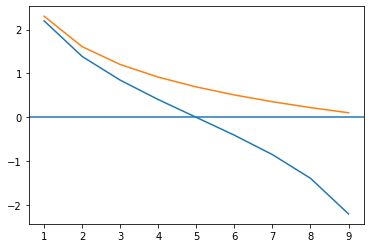

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

N = 10
dfList = np.arange(1, 10, 1)
plt.plot(dfList, [idf4(_) for _ in dfList])
plt.plot(dfList, [idf5(_) for _ in dfList])
plt.axhline(0)
plt.show()

## TF-IDF Weight Schemes
<div align="left">
<table class="wikitable" style="float: top; margin-left: 0; margin-right: 1.5em; margin-top: 0;">
<caption>Recommended tf–idf weighting schemes
</caption>
<tbody><tr>
<th>weighting scheme
</th>
<th>document term weight
</th>
<th>query term weight
</th></tr>
<tr>
<td>1</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle f_{t,d}\cdot \log {\frac {N}{n_{t}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
        <mo>&#x22C5;<!-- ⋅ --></mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mi>N</mi>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle f_{t,d}\cdot \log {\frac {N}{n_{t}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/74db3d91105b74e8450a78fadbf7ea7f241bc737" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.171ex; width:11.377ex; height:5.509ex;" alt="{\displaystyle f_{t,d}\cdot \log {\frac {N}{n_{t}}}}"/></span></td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \left(0.5+0.5{\frac {f_{t,q}}{\max _{t}f_{t,q}}}\right)\cdot \log {\frac {N}{n_{t}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mrow>
          <mo>(</mo>
          <mrow>
            <mn>0.5</mn>
            <mo>+</mo>
            <mn>0.5</mn>
            <mrow class="MJX-TeXAtom-ORD">
              <mfrac>
                <msub>
                  <mi>f</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <mi>t</mi>
                    <mo>,</mo>
                    <mi>q</mi>
                  </mrow>
                </msub>
                <mrow>
                  <munder>
                    <mo movablelimits="true" form="prefix">max</mo>
                    <mrow class="MJX-TeXAtom-ORD">
                      <mi>t</mi>
                    </mrow>
                  </munder>
                  <msub>
                    <mi>f</mi>
                    <mrow class="MJX-TeXAtom-ORD">
                      <mi>t</mi>
                      <mo>,</mo>
                      <mi>q</mi>
                    </mrow>
                  </msub>
                </mrow>
              </mfrac>
            </mrow>
          </mrow>
          <mo>)</mo>
        </mrow>
        <mo>&#x22C5;<!-- ⋅ --></mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mi>N</mi>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \left(0.5+0.5{\frac {f_{t,q}}{\max _{t}f_{t,q}}}\right)\cdot \log {\frac {N}{n_{t}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/fe1629098093a97eb293bd5085009c51c3cdd77b" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.671ex; width:29.854ex; height:6.509ex;" alt="{\displaystyle \left(0.5+0.5{\frac {f_{t,q}}{\max _{t}f_{t,q}}}\right)\cdot \log {\frac {N}{n_{t}}}}"/></span>
</td></tr>
<tr>
<td>2</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle 1+\log f_{t,d}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mn>1</mn>
        <mo>+</mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle 1+\log f_{t,d}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/dc85c57525999f9f224ac5623e606bea2160d171" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -1.005ex; width:10.644ex; height:2.843ex;" alt="1+\log f_{{t,d}}"/></span></td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log \left(1+{\frac {N}{n_{t}}}\right)}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow>
          <mo>(</mo>
          <mrow>
            <mn>1</mn>
            <mo>+</mo>
            <mrow class="MJX-TeXAtom-ORD">
              <mfrac>
                <mi>N</mi>
                <msub>
                  <mi>n</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <mi>t</mi>
                  </mrow>
                </msub>
              </mfrac>
            </mrow>
          </mrow>
          <mo>)</mo>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log \left(1+{\frac {N}{n_{t}}}\right)}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/29f34f3a19a3fec371d5ab2756896a4c3cfc0d96" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.505ex; width:13.453ex; height:6.176ex;" alt="{\displaystyle \log \left(1+{\frac {N}{n_{t}}}\right)}"/></span>
</td></tr>
<tr>
<td>3</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle (1+\log f_{t,d})\cdot \log {\frac {N}{n_{t}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mo stretchy="false">(</mo>
        <mn>1</mn>
        <mo>+</mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
        <mo stretchy="false">)</mo>
        <mo>&#x22C5;<!-- ⋅ --></mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mi>N</mi>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle (1+\log f_{t,d})\cdot \log {\frac {N}{n_{t}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/c271425fa07254a10379f1379e02d0fd034f4f21" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.171ex; width:20.548ex; height:5.509ex;" alt="{\displaystyle (1+\log f_{t,d})\cdot \log {\frac {N}{n_{t}}}}"/></span></td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle (1+\log f_{t,q})\cdot \log {\frac {N}{n_{t}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mo stretchy="false">(</mo>
        <mn>1</mn>
        <mo>+</mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>q</mi>
          </mrow>
        </msub>
        <mo stretchy="false">)</mo>
        <mo>&#x22C5;<!-- ⋅ --></mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mi>N</mi>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle (1+\log f_{t,q})\cdot \log {\frac {N}{n_{t}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/cb8cdf7f351b63973cee045cc98c9efcde04203a" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.171ex; width:20.445ex; height:5.509ex;" alt="{\displaystyle (1+\log f_{t,q})\cdot \log {\frac {N}{n_{t}}}}"/></span>
</td></tr></tbody></table>
</div>

In [59]:
TWM = defaultdict(lambda: defaultdict(float))
DocLength = defaultdict(float)

for j, docs in TDM.items():
    try:
        IDF1 = idf1(len(docs))
        IDF2 = idf2(len(docs))
        IDF4 = idf4(len(docs))

        for i, f in docs.items():
            TF1 = tf1(f, sum(DTM[i].values()))
            TF2 = tf2(f)
            TF3 = tf3(f, max(DTM[i].values()))

            W1 = f*IDF1
            W2 = TF2*1
            W3 = TF2*IDF1
            W4 = TF3*IDF1

            TWM[j][i] = W4
            DocLength[i] += W4 ** 2
    except:
        continue

- Relvance = Similarity
- euclidean = sqrt(t ㅌ V (q - d_i)**2)
- cos theta = q vector * d_i vector / (|q| 굳이 계산 X) * |d_i|

In [60]:
kkma.nouns('가방 가방 가방')

['가방']

In [61]:
kkma.pos('가방 가방 가방')

[('가방', 'NNG'), ('가방', 'NNG'), ('가방', 'NNG')]

In [116]:
# Q = '필로폰 투약 혐의 로버트 할리, 최후 변론서 눈물 아들이 존경했는데'
# Q = '대통령 청와대 국민 정부'
Q = '아베 신조'
_Q = [_[0] for _ in kkma.pos(Q) if _[1].startswith('N') and _[0] in V]

QWM = defaultdict(float)

for t in _Q:
    j = V.index(t)
    QWM[j] += 1

maxFreq = max(QWM.values())

for j in QWM:
    IDF1 = idf1(len(TWM[j]))
    QWM[j] = tf3(QWM[j], maxFreq, 0.5) * idf1(len(TWM[j]))
    
QLength = sqrt(sum([_**2 for _ in QWM.values()]))

In [117]:
QWM

defaultdict(float, {2638: 2.302585092994046, 2639: 2.302585092994046})

In [118]:
from math import sqrt


searchResult = defaultdict(float)
for q_j, w_q in QWM.items():
    for i, w in TWM[q_j].items():
        searchResult[i] += q_j*i

for i, innerProduct in searchResult.items():
    searchResult[i] = innerProduct / (QLength * sqrt(DocLength[i]))

for _ in sorted(searchResult.items(), key=lambda x: x[1], reverse=True):
    print(_[1])
    print(collection[_[0]])
    print()

510.99661480420457
일진복합소재 매연저감장치DPF 사진일진복합소재일진복합소재가 정부 노후 경유차량 퇴출과 매연저감장치DPF 보조금 효과로 매출과 이익이 크게 증가할 것으로 보인다일진복합소재대표 김기현는 매연저감장치 부착 차량이 증가하고 사후관리가 강화됨에 따라 관련 매출이 증가할 것으로 예상한다고 17일 밝혔다일진복합소재는 일진다이아몬드의 자회사지분율 828로 수소연료탱크 CNG가스탱크 등 플라스틱 복합소재 연료탱크와 매연저감장치DPF를 생산하는 친환경 부품기업이다매연저감장치는 노후 경유차량에 부착해 미세먼지와 초미세먼지를 저감해 주는 장치다 미세먼지를 80 이상 저감해 주는 대형 중형 소형 경유차용 제품이 일진복합소재 주력이다 지난해 말 누적기준 국내 9만5000대 해외 2000대 차량에 매연저감장치를 보급했다세계보건기구WHO에 따르면 초미세먼지는 미세먼지보다 급성사망률 2배 만성사망률 40 이상으로 인체에 치명적으로 분류하고 있다 초미세먼지인 질소산화물NOx은 대부분 경유차 건설기계에서 배출되는데 특히 경유차가 핵심이다정부는 미세먼지 개선 예산 중 매연저감장치 지원 예산으로 지난해 본예산 444억원 올해 본예산 444억원1만5000대 분량을 책정했다 올해 추경예산안으로 본예산보다 53배 많은 2370억원8만대 분량을 상정했다 매연저감장치 기능 유지를 위해 정기적인 클리닝이 필요한데 정부가 클리닝 비용도 지급하기로 했다정부는 2021년까지 미세먼지특별법에 적용되는 5등급 차량 280만대를 퇴출시킨다는 계획이어서 내년 미세먼지 개선 예산도 올해 추경 예산을 넘어설 것으로 전망된다일진복합소재 관계자는 매연저감장치 부착 차량이 증가와 사후관리 강화로 매출이 증가할 것면서 매연저감장지 장착 시 정부예산 90 외에 차주의 자기부담금 10를 지난해까지 폐차 시 부과했지만 올해부터는 구매 시점에 부과해 이익 개선에도 도움이 될 것이라고 내다봤다한편 일진복합소재는 수소연료탱크 사업 부문에서도 국내 최초로 CNG 차량용 초경량 복합소재 연료탱크TYPE4를 제조

In [120]:
from math import sqrt


searchResult = defaultdict(float)
for t in V:
    j = V.index(t)
    
    for i, w in TWM[j].items():
        searchResult[i] += (QWM[j] - w)**2

for i, innerProduct in searchResult.items():
    searchResult[i] = -sqrt(innerProduct)

for _ in sorted(searchResult.items(), key=lambda x: x[1], reverse=True):
    print(_[1], len(collection[_[0]].split()))
    print(collection[_[0]])
    print()

-11.739080505790296 122
일본 불매 운동 포스터 사진온라인 커뮤니티국민의 자발적인 일본여행 보이콧이 확산하는 가운데 일부 여행기자들이 일본 팸투어에 나서 빈축을 사고 있다팸투어는 현지 관광당국이 홍보마케팅 차원에서 모든 경비를 부담하는 초청행사다논란의 여행기자들은 오늘17일 출국해 현지 일정을 소화중인 것으로 알려졌다 이 같은 비난에 대해 팸투어 참가단은 오래 전 약속한 일정이어서 팸투어를 떠날 수밖에 없다는 입장인 것으로 알려졌다이에 대해 여행업계의 한 관계자는 변명치고는 너무 빈약하다면서 국민들이 자발적으로 일본여행을 포기하는 마당에 공짜면 양잿물도 마시겠다는 것 아니냐며 비판했다또 초청한 일본의 관광당국 입장에서는 한국기자들이 온 것을 보고 한국을 얼마나 우습게 알겠냐면서 울분을 토했다한편 일부 참가 기자들은 팸투어 사실이 드러나지 않도록 하기 위해 취재기사를 싣지 않겠다는 뜻도 내비친 것으로 전해져 더욱 논란이 일고 있다 박정웅 기자 mtcokr 고수들의 재테크 비법  박학다식 이건희칼럼저작권자  성공을 꿈꾸는 사람들의 경제 뉴스 머니S 무단전재 및 재배포 금지

-13.286494100824571 139
동영상 뉴스주영진의 뉴스브리핑인터뷰를 인용보도할 때는 프로그램명 SBS 주영진의 뉴스브리핑을 정확히 밝혀주시기 바랍니다 저작권은 SBS에 있습니다 방송  SBS 주영진의 뉴스브리핑 월금 14001600 진행  주영진 앵커 대담  윤춘호 SBS 논설실장 강선우 전 민주당 부대변인 이상일 전 국회의원 풍운아 정두언 사망이상일 전 국회의원살아있는 권력 비판매우 용기 있는 정치인MB 정두언과 묵은 감정 털고자 했지만 여건 안 돼강선우 전 민주당 부대변인정두언 진정한 중용의 가치 깨닫게 해윤춘호 SBS 논설실장정두언으로 인해 MB 정부 권력투쟁 적나라하게 드러나권력 정점에서 추락우울증 시달려 굴곡진 정치인생 왜이상일 전 국회의원8년 전 정두언 가상 유서김종필의 정치는 허업 떠올라거친 정치 세계에서 마음의 상처 크게 받은 듯강선우 전 민주당 부